# Beer Preference Prediction: Random Forest Analysis

This notebook focuses on predicting beer preference probability distributions using Random Forest regression. The approach treats each user's preferences as a 13-dimensional input vector that maps to ratings across 9 beers.

## Methodology
- **Data Source**: SQLite database (`beer_study.db`)
- **Input Features**: 13-dimensional vector (9 taste preferences + age + gender + location + beer frequency)
- **Target**: Probability distribution over 9 beers per user
- **Model**: Random Forest to predict beer ratings and derive preference probabilities
- **Validation**: User-grouped cross-validation ensuring preference consistency

## Key Innovation
Instead of predicting individual ratings, we predict a user's complete preference profile across all beers, treating this as a probability distribution problem.

## 1. Import Libraries and Setup

In [10]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Configure plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 11
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"📊 pandas version: {pd.__version__}")
print(f"🤖 sklearn available")
print(f"📈 matplotlib/seaborn available")
print(f"🔢 numpy version: {np.__version__}")

✅ All libraries imported successfully!
📊 pandas version: 2.3.1
🤖 sklearn available
📈 matplotlib/seaborn available
🔢 numpy version: 2.3.2


## 2. Connect to SQLite Database

In [11]:
# Database path (adjust if needed)
DB_PATH = '../backend/beer_study.db'

# Connect to the database
try:
    conn = sqlite3.connect(DB_PATH)
    print("✅ Successfully connected to database!")
    
    # Get table structure
    cursor = conn.cursor()
    cursor.execute("PRAGMA table_info(beer_ratings)")
    columns = cursor.fetchall()
    
    print("\n📋 Database Schema (beer_ratings table):")
    print("-" * 60)
    for col in columns:
        print(f"{col[1]:<25} {col[2]:<15} {'NOT NULL' if col[3] else 'NULL'}")
    
    # Check data availability
    cursor.execute("SELECT COUNT(*) FROM beer_ratings")
    total_rows = cursor.fetchone()[0]
    print(f"\n📊 Total entries in database: {total_rows}")
    
    if total_rows == 0:
        print("⚠️  Warning: Database is empty! Please collect some data first.")
    
except Exception as e:
    print(f"❌ Error connecting to database: {e}")
    print("📍 Make sure the database path is correct and the file exists.")

✅ Successfully connected to database!

📋 Database Schema (beer_ratings table):
------------------------------------------------------------
id                        INTEGER         NULL
user_id                   VARCHAR(36)     NOT NULL
beer_name                 VARCHAR(100)    NOT NULL
rating                    INTEGER         NOT NULL
age                       INTEGER         NOT NULL
gender                    VARCHAR(20)     NOT NULL
latitude                  FLOAT           NOT NULL
longitude                 FLOAT           NOT NULL
dark_white_chocolate      INTEGER         NOT NULL
curry_cucumber            INTEGER         NOT NULL
vanilla_lemon             INTEGER         NOT NULL
caramel_wasabi            INTEGER         NOT NULL
blue_mozzarella           INTEGER         NOT NULL
sparkling_sweet           INTEGER         NOT NULL
barbecue_ketchup          INTEGER         NOT NULL
tropical_winter           INTEGER         NOT NULL
early_night               INTEGER         NOT NU

## 3. Load and Explore Data

In [12]:
# Load data from SQLite database
query = "SELECT * FROM beer_ratings"

try:
    df = pd.read_sql_query(query, conn)
    print("✅ Data loaded successfully!")
    print(f"📊 Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns")
    
    # Display basic information
    print("\n📋 Dataset Info:")
    print("-" * 40)
    print(f"• Total entries: {len(df)}")
    print(f"• Unique users: {df['user_id'].nunique()}")
    print(f"• Unique beers: {df['beer_name'].nunique()}")
    print(f"• Date range: {df['submitted_at'].min()} to {df['submitted_at'].max()}")
    
    # Check for missing values
    print("\n🔍 Missing Values:")
    missing_data = df.isnull().sum()
    if missing_data.sum() == 0:
        print("✅ No missing values found!")
    else:
        print(missing_data[missing_data > 0])
    
    # Display first few rows
    print("\n🔍 Sample Data (first 3 rows):")
    display(df.head(3))
    
except Exception as e:
    print(f"❌ Error loading data: {e}")
    df = None

✅ Data loaded successfully!
📊 Dataset shape: 707 rows × 20 columns

📋 Dataset Info:
----------------------------------------
• Total entries: 707
• Unique users: 74
• Unique beers: 18
• Date range: 2025-08-05 17:58:28.466534 to 2025-08-05 19:57:58.441806

🔍 Missing Values:
✅ No missing values found!

🔍 Sample Data (first 3 rows):


,id,user_id,beer_name,rating,age,gender,latitude,longitude,dark_white_chocolate,curry_cucumber,vanilla_lemon,caramel_wasabi,blue_mozzarella,sparkling_sweet,barbecue_ketchup,tropical_winter,early_night,beer_frequency,drinks_alcohol,submitted_at
0,1,0f1b9d70-1f5b-4f30-a745-0b789210ad27,Beer 1,5,22,male,52.547207,13.459548,5,5,5,10,5,5,5,5,5,never,1,2025-08-05 17:58:28.466534
1,2,b3eeff5d-b8a8-402e-b708-1dc13f724fec,Beer 1,8,24,female,48.983822,8.415527,2,3,1,0,3,5,5,8,2,once_a_week,1,2025-08-05 18:23:00.689156
2,3,7cd27879-3145-47a7-938b-39147abc36ac,Beer 5,7,24,female,38.709357,-9.139938,1,4,7,2,7,5,2,5,7,multiple_times_a_week,1,2025-08-05 18:39:37.513760


## 4. Feature Correlation Analysis and Data Exploration

🔍 13-Dimensional Feature Vector:
Taste Preferences (9 features):
   1. Dark White Chocolate
   2. Curry Cucumber
   3. Vanilla Lemon
   4. Caramel Wasabi
   5. Blue Mozzarella
   6. Sparkling Sweet
   7. Barbecue Ketchup
   8. Tropical Winter
   9. Early Night

User Characteristics (4 features):
  10. Age
  11. Gender (encoded)
  12. Latitude
  13. Beer Frequency (encoded)


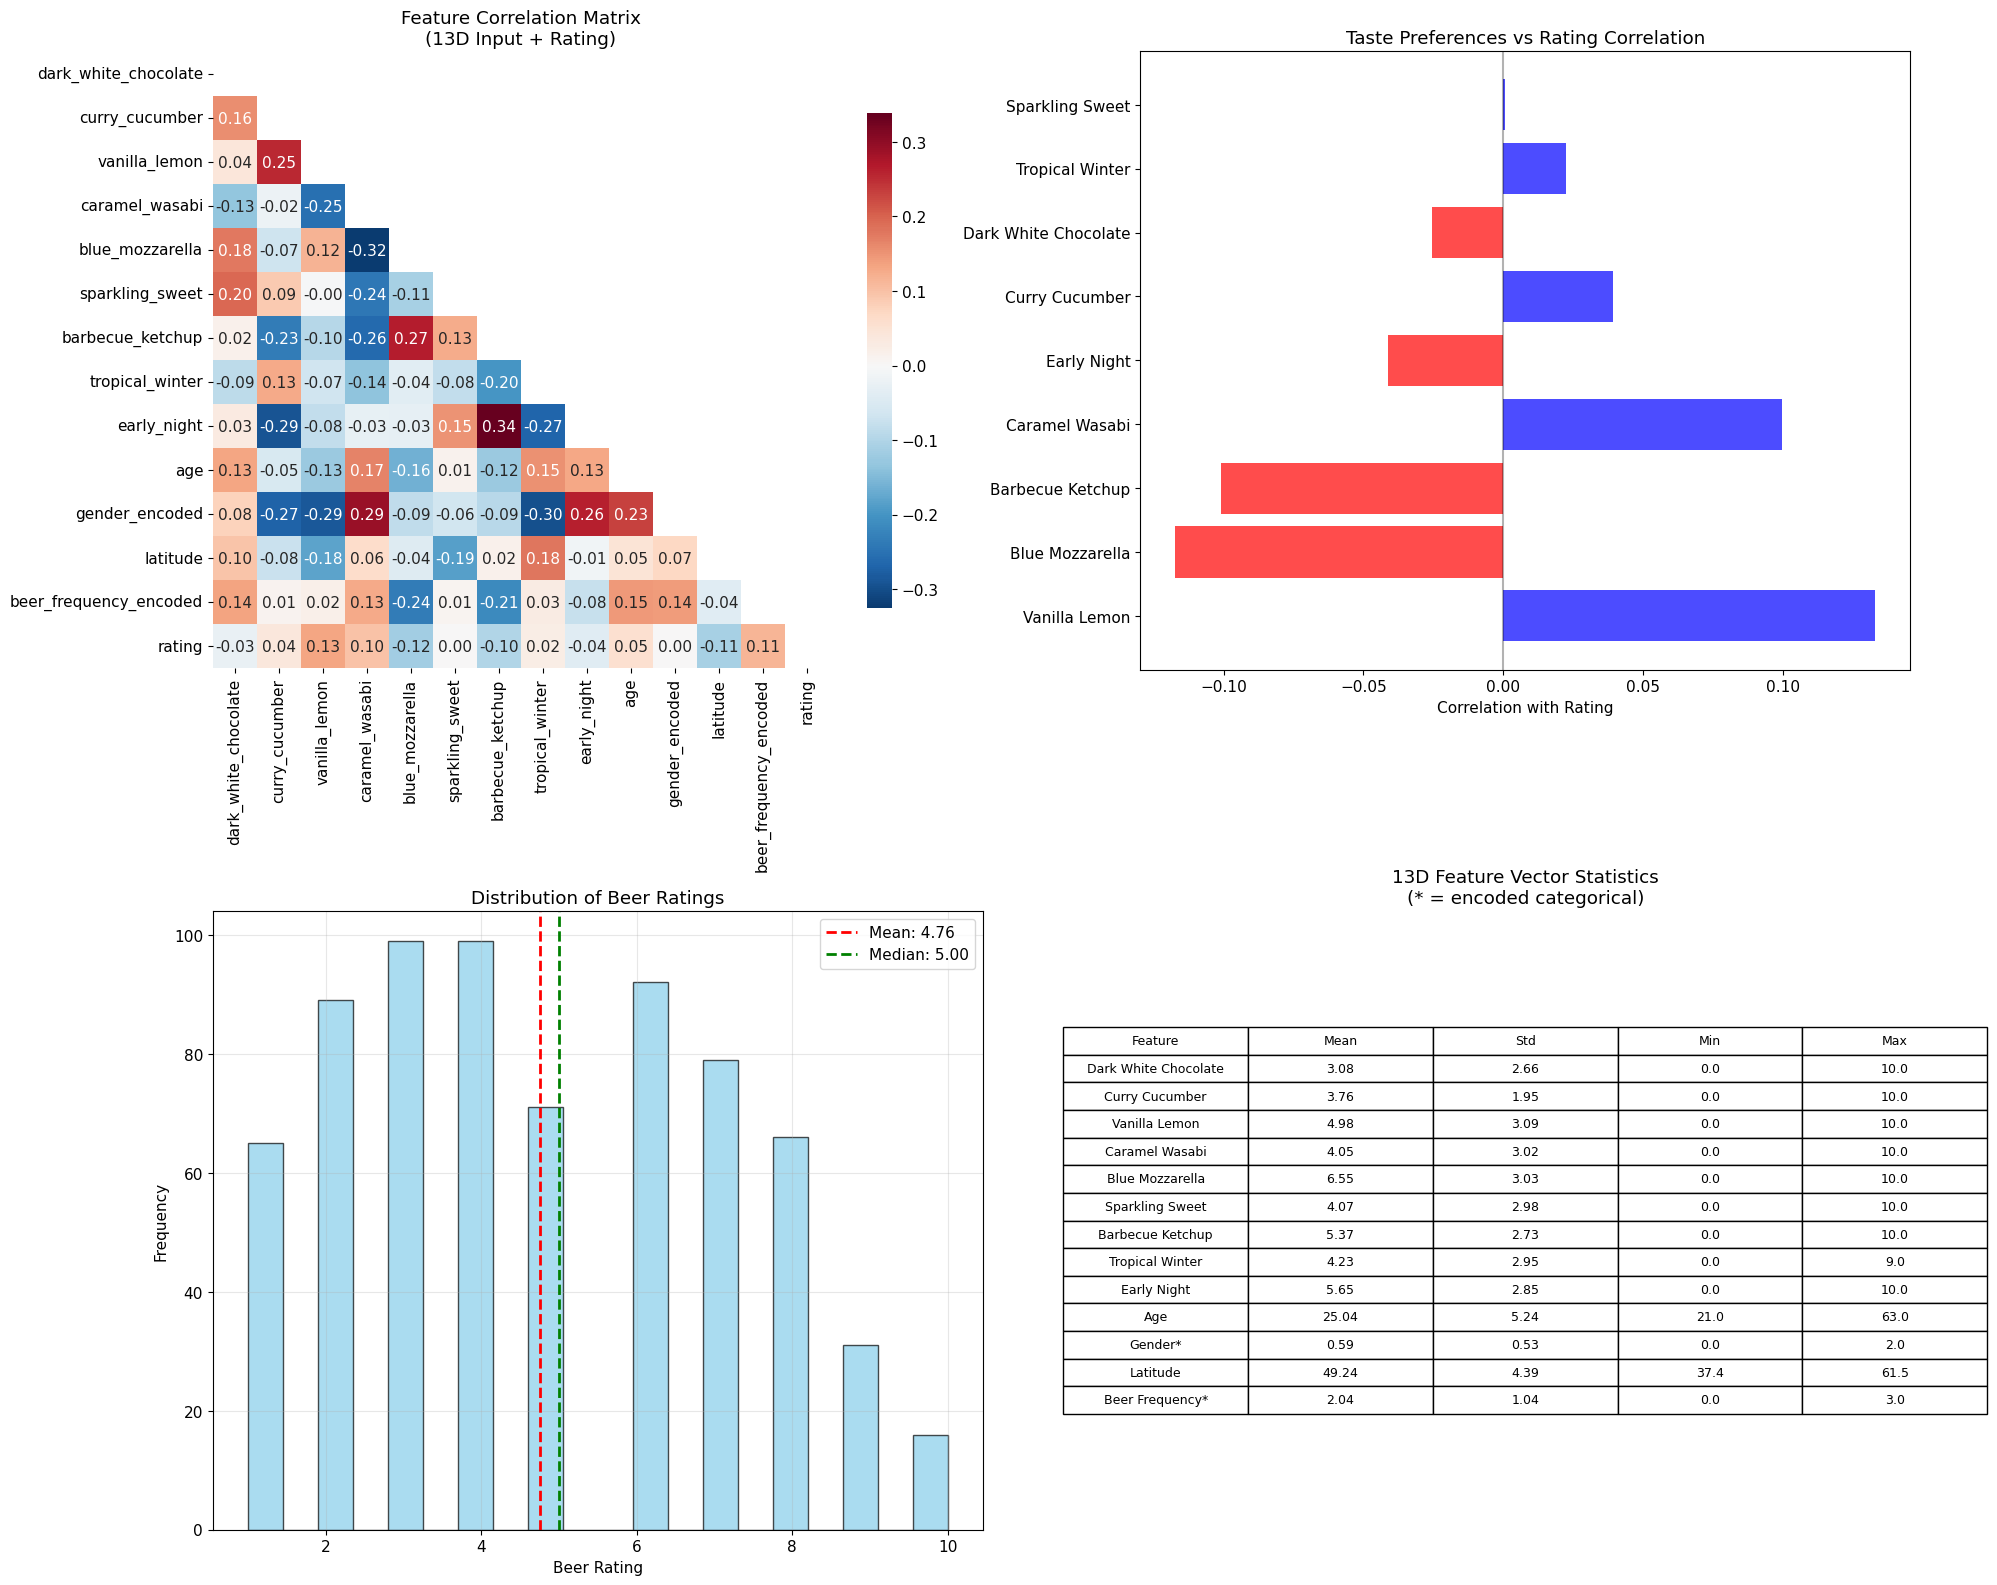


📊 Key Correlation Insights:
----------------------------------------
Strongest taste-rating correlations:
  • Vanilla Lemon: 0.133
  • Blue Mozzarella: -0.117
  • Barbecue Ketchup: -0.101

Weakest taste-rating correlations:
  • Dark White Chocolate: -0.025
  • Tropical Winter: 0.023
  • Sparkling Sweet: 0.001

📈 Dataset Statistics:
  • Total ratings: 707
  • Rating range: 1 - 10
  • Rating mean ± std: 4.76 ± 2.44


In [13]:
if df is not None and len(df) > 0:
    # Create processed dataset
    df_processed = df.copy()
    
    # Convert timestamp to datetime
    df_processed['submitted_at'] = pd.to_datetime(df_processed['submitted_at'])
    
    # Define the 13-dimensional feature vector
    # 9 taste preferences + 4 user characteristics
    taste_features = [
        'dark_white_chocolate', 'curry_cucumber', 'vanilla_lemon', 'caramel_wasabi',
        'blue_mozzarella', 'sparkling_sweet', 'barbecue_ketchup', 'tropical_winter', 'early_night'
    ]
    
    # Encode categorical variables for the 13-dimensional vector
    le_gender = LabelEncoder()
    df_processed['gender_encoded'] = le_gender.fit_transform(df_processed['gender'])
    
    le_frequency = LabelEncoder()
    df_processed['beer_frequency_encoded'] = le_frequency.fit_transform(df_processed['beer_frequency'])
    
    # Complete 13-dimensional feature vector
    feature_vector_13d = taste_features + ['age', 'gender_encoded', 'latitude', 'beer_frequency_encoded']
    
    print("🔍 13-Dimensional Feature Vector:")
    print("=" * 50)
    print("Taste Preferences (9 features):")
    for i, feature in enumerate(taste_features, 1):
        print(f"  {i:2}. {feature.replace('_', ' ').title()}")
    print("\nUser Characteristics (4 features):")
    print(f"  10. Age")
    print(f"  11. Gender (encoded)")
    print(f"  12. Latitude")
    print(f"  13. Beer Frequency (encoded)")
    
    # Create correlation matrix for all features
    correlation_features = taste_features + ['age', 'gender_encoded', 'latitude', 'beer_frequency_encoded', 'rating']
    corr_matrix = df_processed[correlation_features].corr()
    
    # Visualization: Correlation Heatmap
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1. Full correlation heatmap
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8}, ax=ax1)
    ax1.set_title('Feature Correlation Matrix\n(13D Input + Rating)')
    
    # 2. Taste preferences correlation with rating
    taste_rating_corr = df_processed[taste_features + ['rating']].corr()['rating'].drop('rating').sort_values(key=abs, ascending=False)
    colors = ['red' if x < 0 else 'blue' for x in taste_rating_corr.values]
    ax2.barh(range(len(taste_rating_corr)), taste_rating_corr.values, color=colors, alpha=0.7)
    ax2.set_yticks(range(len(taste_rating_corr)))
    ax2.set_yticklabels([f.replace('_', ' ').title() for f in taste_rating_corr.index])
    ax2.set_xlabel('Correlation with Rating')
    ax2.set_title('Taste Preferences vs Rating Correlation')
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # 3. Distribution of ratings
    ax3.hist(df_processed['rating'], bins=min(20, len(df_processed)//5), alpha=0.7, color='skyblue', edgecolor='black')
    ax3.axvline(df_processed['rating'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_processed["rating"].mean():.2f}')
    ax3.axvline(df_processed['rating'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df_processed["rating"].median():.2f}')
    ax3.set_xlabel('Beer Rating')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of Beer Ratings')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Feature distribution summary
    feature_stats = df_processed[feature_vector_13d].describe().T
    ax4.axis('off')
    table_data = []
    for idx, row in feature_stats.iterrows():
        name = idx.replace('_', ' ').title()
        if 'encoded' in idx:
            name = name.replace(' Encoded', '*')
        table_data.append([name, f"{row['mean']:.2f}", f"{row['std']:.2f}", f"{row['min']:.1f}", f"{row['max']:.1f}"])
    
    table = ax4.table(cellText=table_data, 
                     colLabels=['Feature', 'Mean', 'Std', 'Min', 'Max'],
                     cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    ax4.set_title('13D Feature Vector Statistics\n(* = encoded categorical)')
    
    plt.tight_layout()
    plt.show()
    
    # Print correlation insights
    print("\n📊 Key Correlation Insights:")
    print("-" * 40)
    print("Strongest taste-rating correlations:")
    for feature, corr in taste_rating_corr.head(3).items():
        print(f"  • {feature.replace('_', ' ').title()}: {corr:.3f}")
    
    print("\nWeakest taste-rating correlations:")
    for feature, corr in taste_rating_corr.tail(3).items():
        print(f"  • {feature.replace('_', ' ').title()}: {corr:.3f}")
    
    # Feature statistics
    print(f"\n📈 Dataset Statistics:")
    print(f"  • Total ratings: {len(df_processed)}")
    print(f"  • Rating range: {df_processed['rating'].min()} - {df_processed['rating'].max()}")
    print(f"  • Rating mean ± std: {df_processed['rating'].mean():.2f} ± {df_processed['rating'].std():.2f}")
    
else:
    print("❌ No data available for correlation analysis")

## 5. Data Splitting: Alcoholic vs Non-Alcoholic Beers

🍺 Dataset Split Results:
📊 Total dataset: 707 ratings
🍻 Alcoholic beers: 511 ratings (72.3%)
🚫 Non-alcoholic beers: 196 ratings (27.7%)

🍻 Alcoholic Beer Distribution:
  • Beer 1: 70 ratings
  • Beer 2: 60 ratings
  • Beer 3: 54 ratings
  • Beer 4: 58 ratings
  • Beer 5: 54 ratings
  • Beer 6: 51 ratings
  • Beer 7: 55 ratings
  • Beer 8: 54 ratings
  • Beer 9: 55 ratings

🚫 Non-Alcoholic Beer Distribution:
  • Beer A: 23 ratings
  • Beer B: 22 ratings
  • Beer C: 23 ratings
  • Beer D: 24 ratings
  • Beer E: 20 ratings
  • Beer F: 20 ratings
  • Beer G: 23 ratings
  • Beer H: 19 ratings
  • Beer I: 22 ratings

👥 User Participation Analysis:
  • Users rating alcoholic beers: 55
  • Users rating non-alcoholic beers: 19
  • Users rating both categories: 0
  • Users rating only alcoholic: 55
  • Users rating only non-alcoholic: 19


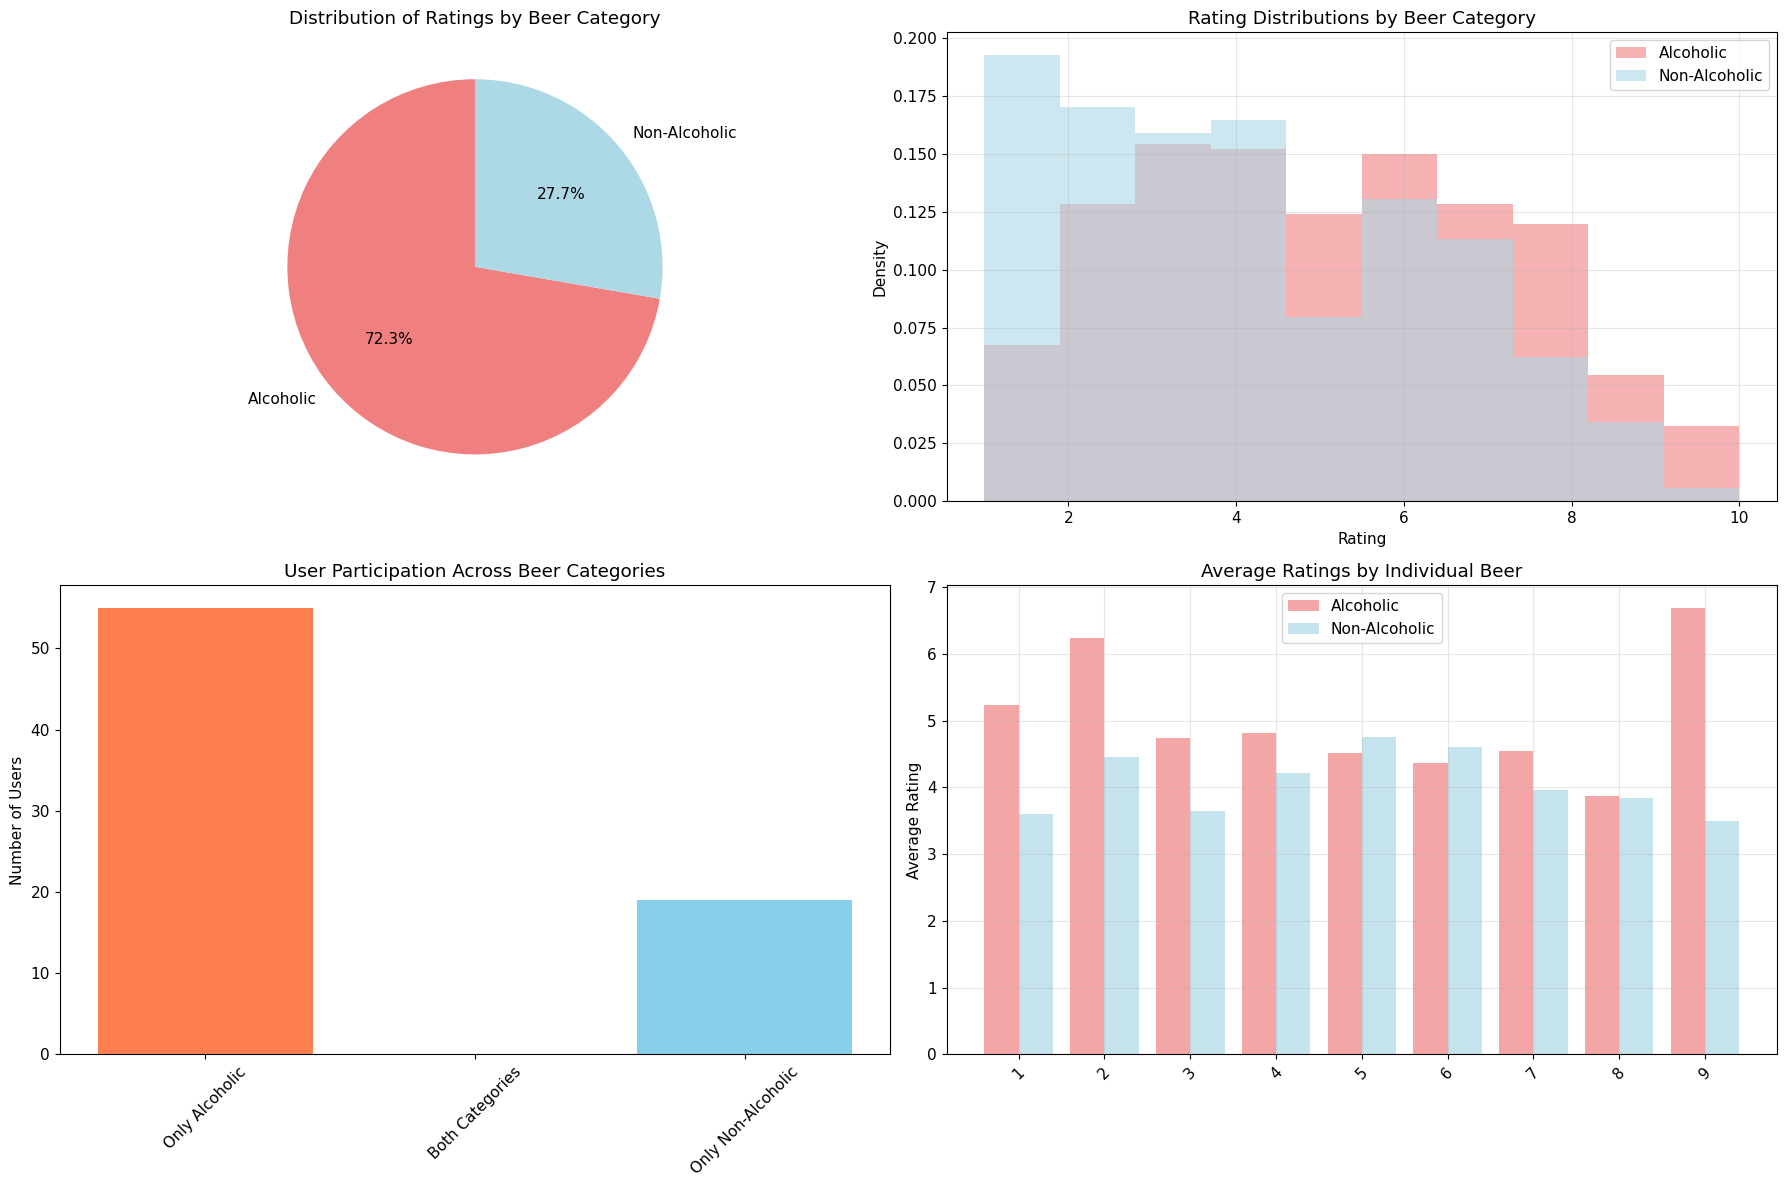


📈 Statistical Comparison:
  • Alcoholic beers - Mean: 5.03, Std: 2.41
  • Non-alcoholic beers - Mean: 4.05, Std: 2.38
  • T-test p-value: 0.0000 (Significant difference)


In [14]:
if df is not None and len(df_processed) > 0:
    # Create beer category classification
    # Beer names with numbers (1-9) are alcoholic, letters (A-I) are non-alcoholic
    df_processed['is_alcoholic'] = df_processed['beer_name'].str.contains(r'Beer [0-9]', regex=True)
    df_processed['beer_category'] = df_processed['is_alcoholic'].map({True: 'Alcoholic', False: 'Non-Alcoholic'})
    
    # Extract beer identifier for mapping
    df_processed['beer_id'] = df_processed['beer_name'].str.extract(r'Beer ([A-Z0-9])')
    
    # Split datasets
    df_alcoholic = df_processed[df_processed['is_alcoholic'] == True].copy()
    df_non_alcoholic = df_processed[df_processed['is_alcoholic'] == False].copy()
    
    print("🍺 Dataset Split Results:")
    print("=" * 50)
    print(f"📊 Total dataset: {len(df_processed)} ratings")
    print(f"🍻 Alcoholic beers: {len(df_alcoholic)} ratings ({len(df_alcoholic)/len(df_processed)*100:.1f}%)")
    print(f"🚫 Non-alcoholic beers: {len(df_non_alcoholic)} ratings ({len(df_non_alcoholic)/len(df_processed)*100:.1f}%)")
    
    # Analyze beer distribution
    print(f"\n🍻 Alcoholic Beer Distribution:")
    alc_beer_counts = df_alcoholic['beer_name'].value_counts().sort_index()
    for beer, count in alc_beer_counts.items():
        print(f"  • {beer}: {count} ratings")
    
    print(f"\n🚫 Non-Alcoholic Beer Distribution:")
    non_alc_beer_counts = df_non_alcoholic['beer_name'].value_counts().sort_index()
    for beer, count in non_alc_beer_counts.items():
        print(f"  • {beer}: {count} ratings")
    
    # Analyze user participation across categories
    users_alcoholic = set(df_alcoholic['user_id'].unique())
    users_non_alcoholic = set(df_non_alcoholic['user_id'].unique())
    users_both = users_alcoholic.intersection(users_non_alcoholic)
    users_only_alcoholic = users_alcoholic - users_non_alcoholic
    users_only_non_alcoholic = users_non_alcoholic - users_alcoholic
    
    print(f"\n👥 User Participation Analysis:")
    print(f"  • Users rating alcoholic beers: {len(users_alcoholic)}")
    print(f"  • Users rating non-alcoholic beers: {len(users_non_alcoholic)}")
    print(f"  • Users rating both categories: {len(users_both)}")
    print(f"  • Users rating only alcoholic: {len(users_only_alcoholic)}")
    print(f"  • Users rating only non-alcoholic: {len(users_only_non_alcoholic)}")
    
    # Visualize the split
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    
    # 1. Beer category distribution
    categories = ['Alcoholic', 'Non-Alcoholic']
    counts = [len(df_alcoholic), len(df_non_alcoholic)]
    colors = ['lightcoral', 'lightblue']
    ax1.pie(counts, labels=categories, autopct='%1.1f%%', colors=colors, startangle=90)
    ax1.set_title('Distribution of Ratings by Beer Category')
    
    # 2. Rating distributions by category
    ax2.hist(df_alcoholic['rating'], bins=10, alpha=0.6, label='Alcoholic', color='lightcoral', density=True)
    ax2.hist(df_non_alcoholic['rating'], bins=10, alpha=0.6, label='Non-Alcoholic', color='lightblue', density=True)
    ax2.set_xlabel('Rating')
    ax2.set_ylabel('Density')
    ax2.set_title('Rating Distributions by Beer Category')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. User overlap visualization
    user_categories = ['Only Alcoholic', 'Both Categories', 'Only Non-Alcoholic']
    user_counts = [len(users_only_alcoholic), len(users_both), len(users_only_non_alcoholic)]
    ax3.bar(user_categories, user_counts, color=['coral', 'purple', 'skyblue'])
    ax3.set_ylabel('Number of Users')
    ax3.set_title('User Participation Across Beer Categories')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Average ratings by individual beers
    all_beer_avg = df_processed.groupby(['beer_name', 'beer_category'])['rating'].mean().reset_index()
    alcoholic_avg = all_beer_avg[all_beer_avg['beer_category'] == 'Alcoholic']
    non_alcoholic_avg = all_beer_avg[all_beer_avg['beer_category'] == 'Non-Alcoholic']
    
    x_alc = np.arange(len(alcoholic_avg))
    x_non_alc = np.arange(len(non_alcoholic_avg))
    
    ax4.bar(x_alc - 0.2, alcoholic_avg['rating'], 0.4, label='Alcoholic', color='lightcoral', alpha=0.7)
    ax4.bar(x_non_alc + 0.2, non_alcoholic_avg['rating'], 0.4, label='Non-Alcoholic', color='lightblue', alpha=0.7)
    
    all_beer_names = list(alcoholic_avg['beer_name']) + list(non_alcoholic_avg['beer_name'])
    ax4.set_xticks(range(max(len(alcoholic_avg), len(non_alcoholic_avg))))
    ax4.set_xticklabels([name.replace('Beer ', '') for name in all_beer_names[:max(len(alcoholic_avg), len(non_alcoholic_avg))]], rotation=45)
    ax4.set_ylabel('Average Rating')
    ax4.set_title('Average Ratings by Individual Beer')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical comparison
    from scipy import stats
    if len(df_alcoholic) > 0 and len(df_non_alcoholic) > 0:
        t_stat, p_value = stats.ttest_ind(df_alcoholic['rating'], df_non_alcoholic['rating'])
        print(f"\n📈 Statistical Comparison:")
        print(f"  • Alcoholic beers - Mean: {df_alcoholic['rating'].mean():.2f}, Std: {df_alcoholic['rating'].std():.2f}")
        print(f"  • Non-alcoholic beers - Mean: {df_non_alcoholic['rating'].mean():.2f}, Std: {df_non_alcoholic['rating'].std():.2f}")
        print(f"  • T-test p-value: {p_value:.4f} ({'Significant' if p_value < 0.05 else 'Not significant'} difference)")
    
else:
    print("❌ No data available for beer category analysis")

## 6. User Grouping and Preference Consistency Validation

👥 User Grouping and Preference Consistency Analysis
📊 User Data Consistency Check:
  • Total unique users: 74
  • Users with multiple ratings: 72
  • ✅ All user preferences are consistent!

📋 User-Level Dataset Created:
  • Shape: (74, 14)
  • Features per user: 13 (13D vector)

🔍 Sample User Data (first 3 users):


,user_id,age,gender_encoded,latitude,beer_frequency_encoded,dark_white_chocolate,curry_cucumber,vanilla_lemon,caramel_wasabi,blue_mozzarella,sparkling_sweet,barbecue_ketchup,tropical_winter,early_night
0,00bab447-25b8-48d2-934b-2d90b54b0998,23,0,40.480381,3,1,3,8,2,2,8,8,2,7
1,023421c3-e891-496b-8853-365f914bd505,23,1,52.392363,1,9,5,9,1,9,3,3,1,6
2,0579eb7f-3faf-44ec-b2f5-281143093267,23,1,48.134443,1,1,5,0,5,8,6,2,5,7



📈 User Rating Patterns:
  • Average ratings per user: 9.6
  • Users rating all 9 alcoholic beers: 24
  • Users rating all 9 non-alcoholic beers: 8
  • Users rating all 18 beers: 0


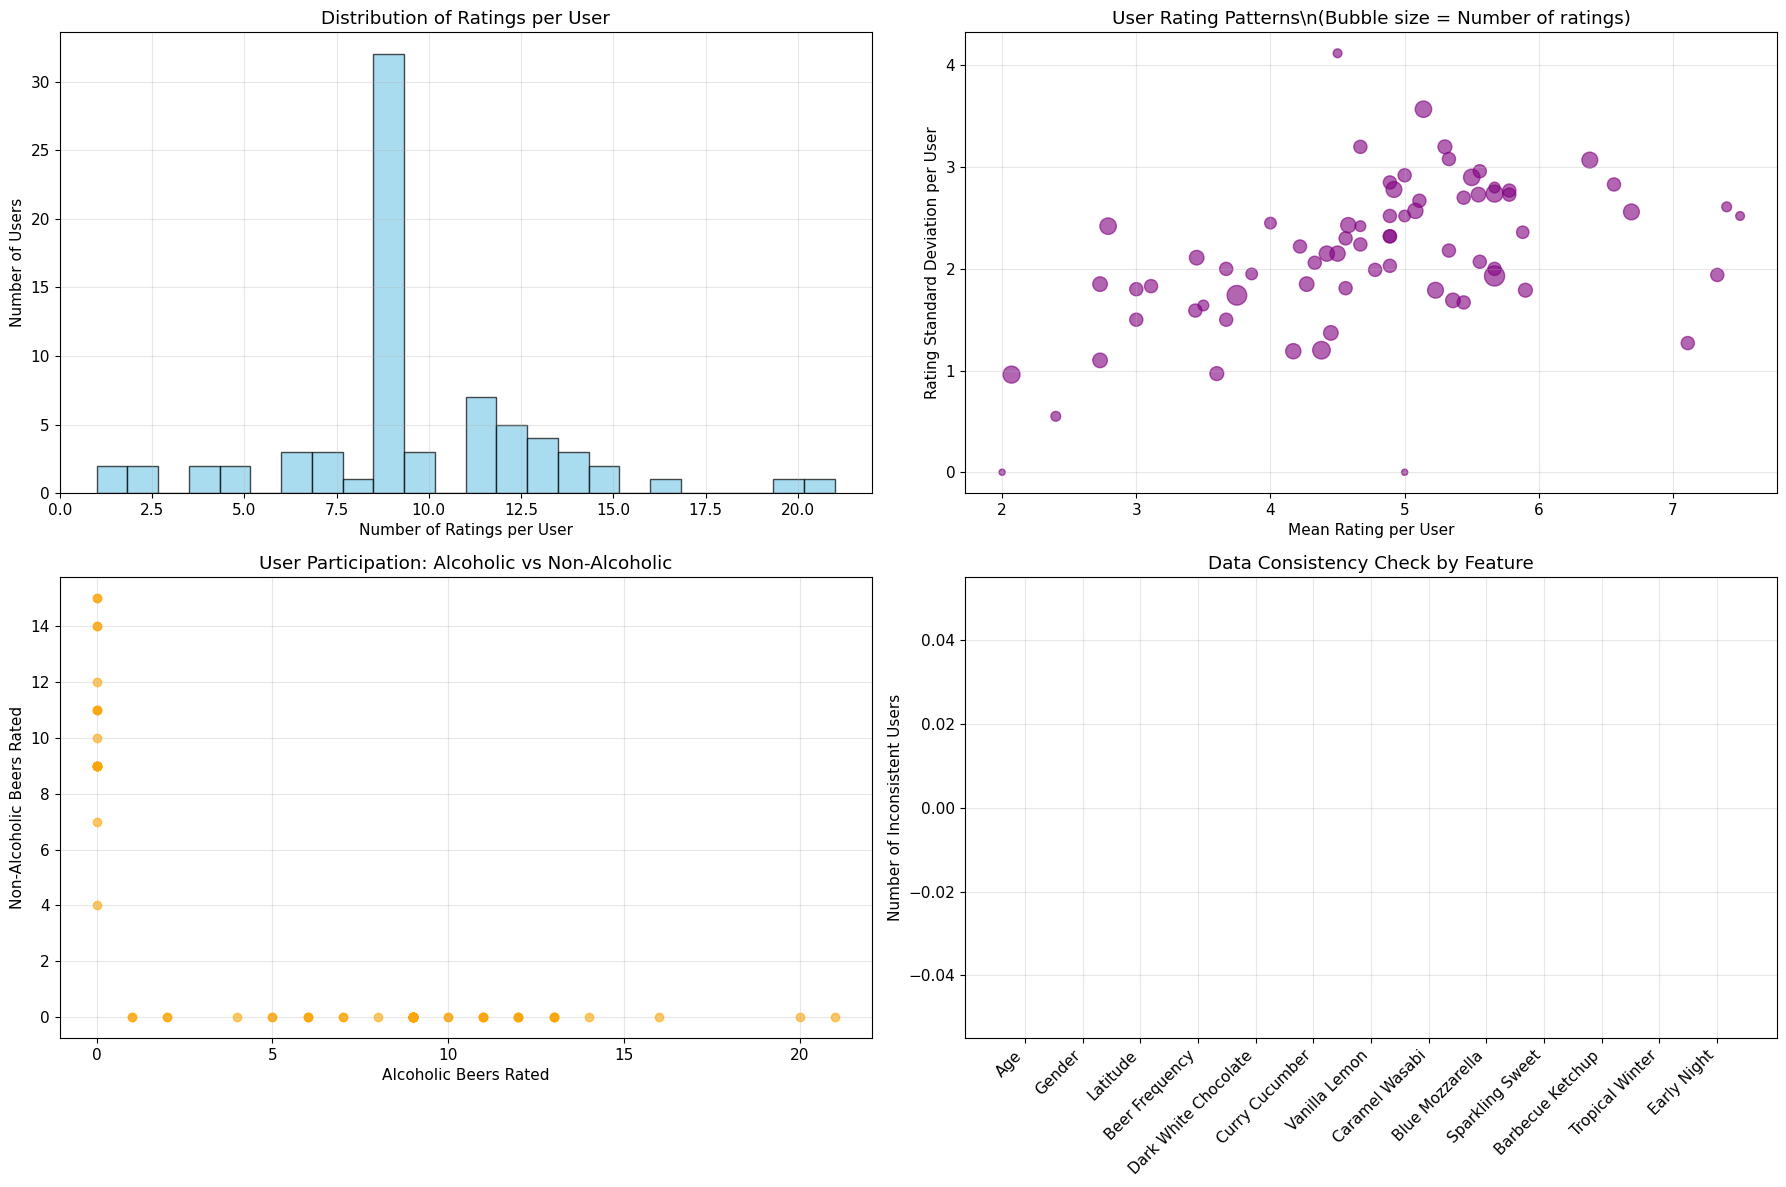

✅ User grouping analysis complete!
📊 Ready for probability distribution modeling with 74 users


In [15]:
if df is not None and len(df_processed) > 0:
    print("👥 User Grouping and Preference Consistency Analysis")
    print("=" * 60)
    
    # Group by user_id and check preference consistency
    user_groups = df_processed.groupby('user_id').agg({
        # User characteristics (should be consistent)
        'age': ['first', 'nunique'],
        'gender': ['first', 'nunique'],
        'latitude': ['first', 'nunique'],
        'beer_frequency': ['first', 'nunique'],
        'drinks_alcohol': ['first', 'nunique'],
        
        # Taste preferences (should be consistent)
        'dark_white_chocolate': ['first', 'nunique'],
        'curry_cucumber': ['first', 'nunique'],
        'vanilla_lemon': ['first', 'nunique'],
        'caramel_wasabi': ['first', 'nunique'],
        'blue_mozzarella': ['first', 'nunique'],
        'sparkling_sweet': ['first', 'nunique'],
        'barbecue_ketchup': ['first', 'nunique'],
        'tropical_winter': ['first', 'nunique'],
        'early_night': ['first', 'nunique'],
        
        # Beer ratings (should vary)
        'rating': ['count', 'mean', 'std'],
        'beer_name': 'nunique'
    }).round(2)
    
    # Flatten column names
    user_groups.columns = ['_'.join(col).strip() for col in user_groups.columns.values]
    
    # Check for inconsistencies in user preferences
    inconsistent_columns = []
    for col in user_groups.columns:
        if 'nunique' in col and not col.startswith('rating') and not col.startswith('beer_name'):
            if (user_groups[col] > 1).any():
                inconsistent_columns.append(col)
    
    print(f"📊 User Data Consistency Check:")
    print(f"  • Total unique users: {len(user_groups)}")
    print(f"  • Users with multiple ratings: {len(user_groups[user_groups['rating_count'] > 1])}")
    
    if inconsistent_columns:
        print(f"  • ⚠️  Inconsistent user data found in: {', '.join(inconsistent_columns)}")
        print(f"  • Users with inconsistencies: {len(user_groups[(user_groups[inconsistent_columns] > 1).any(axis=1)])}")
    else:
        print(f"  • ✅ All user preferences are consistent!")
    
    # Create user-level dataset with consistent preferences
    user_level_features = []
    for user_id in user_groups.index:
        user_data = df_processed[df_processed['user_id'] == user_id].iloc[0]
        user_features = {
            'user_id': user_id,
            'age': user_data['age'],
            'gender_encoded': user_data['gender_encoded'],
            'latitude': user_data['latitude'],
            'beer_frequency_encoded': user_data['beer_frequency_encoded']
        }
        # Add taste preferences
        for taste_feature in taste_features:
            user_features[taste_feature] = user_data[taste_feature]
        
        user_level_features.append(user_features)
    
    df_users = pd.DataFrame(user_level_features)
    
    print(f"\n📋 User-Level Dataset Created:")
    print(f"  • Shape: {df_users.shape}")
    print(f"  • Features per user: {len(feature_vector_13d)} (13D vector)")
    
    # Show sample of user data
    print(f"\n🔍 Sample User Data (first 3 users):")
    display(df_users.head(3))
    
    # Analyze rating patterns per user
    user_rating_stats = df_processed.groupby('user_id').agg({
        'rating': ['count', 'mean', 'std', 'min', 'max'],
        'beer_name': lambda x: len(set(x)),  # unique beers rated
        'is_alcoholic': 'sum'  # number of alcoholic beers rated
    }).round(2)
    
    user_rating_stats.columns = ['rating_count', 'rating_mean', 'rating_std', 'rating_min', 'rating_max', 'unique_beers', 'alcoholic_count']
    user_rating_stats['non_alcoholic_count'] = user_rating_stats['rating_count'] - user_rating_stats['alcoholic_count']
    
    print(f"\n📈 User Rating Patterns:")
    print(f"  • Average ratings per user: {user_rating_stats['rating_count'].mean():.1f}")
    print(f"  • Users rating all 9 alcoholic beers: {len(user_rating_stats[user_rating_stats['alcoholic_count'] == 9])}")
    print(f"  • Users rating all 9 non-alcoholic beers: {len(user_rating_stats[user_rating_stats['non_alcoholic_count'] == 9])}")
    print(f"  • Users rating all 18 beers: {len(user_rating_stats[user_rating_stats['rating_count'] == 18])}")
    
    # Visualize user patterns
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    
    # 1. Distribution of ratings per user
    ax1.hist(user_rating_stats['rating_count'], bins=max(5, len(user_rating_stats)//3), 
             alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_xlabel('Number of Ratings per User')
    ax1.set_ylabel('Number of Users')
    ax1.set_title('Distribution of Ratings per User')
    ax1.grid(True, alpha=0.3)
    
    # 2. User rating means vs standard deviations
    ax2.scatter(user_rating_stats['rating_mean'], user_rating_stats['rating_std'], 
               s=user_rating_stats['rating_count']*10, alpha=0.6, color='purple')
    ax2.set_xlabel('Mean Rating per User')
    ax2.set_ylabel('Rating Standard Deviation per User')
    ax2.set_title('User Rating Patterns\\n(Bubble size = Number of ratings)')
    ax2.grid(True, alpha=0.3)
    
    # 3. Alcoholic vs Non-alcoholic preferences by user
    ax3.scatter(user_rating_stats['alcoholic_count'], user_rating_stats['non_alcoholic_count'], 
               alpha=0.6, color='orange')
    ax3.set_xlabel('Alcoholic Beers Rated')
    ax3.set_ylabel('Non-Alcoholic Beers Rated')
    ax3.set_title('User Participation: Alcoholic vs Non-Alcoholic')
    ax3.grid(True, alpha=0.3)
    
    # 4. Consistency validation visualization
    consistency_features = ['age', 'gender', 'latitude', 'beer_frequency'] + taste_features
    consistency_check = []
    
    for feature in consistency_features:
        if feature in df_processed.columns:
            nunique_col = f"{feature}_nunique"
            if nunique_col in user_groups.columns:
                inconsistent_users = (user_groups[nunique_col] > 1).sum()
                consistency_check.append({'Feature': feature.replace('_', ' ').title(), 
                                        'Inconsistent_Users': inconsistent_users})
    
    if consistency_check:
        consistency_df = pd.DataFrame(consistency_check)
        ax4.bar(range(len(consistency_df)), consistency_df['Inconsistent_Users'], 
               color='red', alpha=0.7)
        ax4.set_xticks(range(len(consistency_df)))
        ax4.set_xticklabels(consistency_df['Feature'], rotation=45, ha='right')
        ax4.set_ylabel('Number of Inconsistent Users')
        ax4.set_title('Data Consistency Check by Feature')
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'All user data\\nis consistent!', 
                ha='center', va='center', transform=ax4.transAxes, 
                fontsize=16, color='green', weight='bold')
        ax4.set_title('Data Consistency Status')
    
    plt.tight_layout()
    plt.show()
    
    # Store processed data for next section
    globals()['df_users'] = df_users
    globals()['user_rating_stats'] = user_rating_stats
    
    print(f"✅ User grouping analysis complete!")
    print(f"📊 Ready for probability distribution modeling with {len(df_users)} users")
    
else:
    print("❌ No data available for user grouping analysis")

## 7. Random Forest Model: 13D Input → Beer Rating Predictions

🌲 Random Forest Model for Beer Preference Prediction
📊 Training Dataset Created:
  • Total training examples: 707
  • Unique users: 74
  • Unique beers: 18

🔢 Feature Engineering:
  • User features (13D): 13
  • Beer encoding: 18 (one-hot)
  • Total input features: 31
  • Training examples: 707

🎯 Cross-Validation Results (Group-based by User):
  • Full model (13D + beer): R² = 0.013 ± 0.157
  • User features only (13D): R² = -0.032 ± 0.118

📊 Top 15 Most Important Features:

🎯 Cross-Validation Results (Group-based by User):
  • Full model (13D + beer): R² = 0.013 ± 0.157
  • User features only (13D): R² = -0.032 ± 0.118

📊 Top 15 Most Important Features:


,Feature,Importance,Type
11,user_latitude,0.084587,User
21,beer_9,0.081813,Beer
3,user_caramel_wasabi,0.065370,User
14,beer_2,0.063581,Beer
2,user_vanilla_lemon,0.059555,User
8,user_early_night,0.051154,User
5,user_sparkling_sweet,0.044069,User
9,user_age,0.043687,User
7,user_tropical_winter,0.041208,User
6,user_barbecue_ketchup,0.040618,User


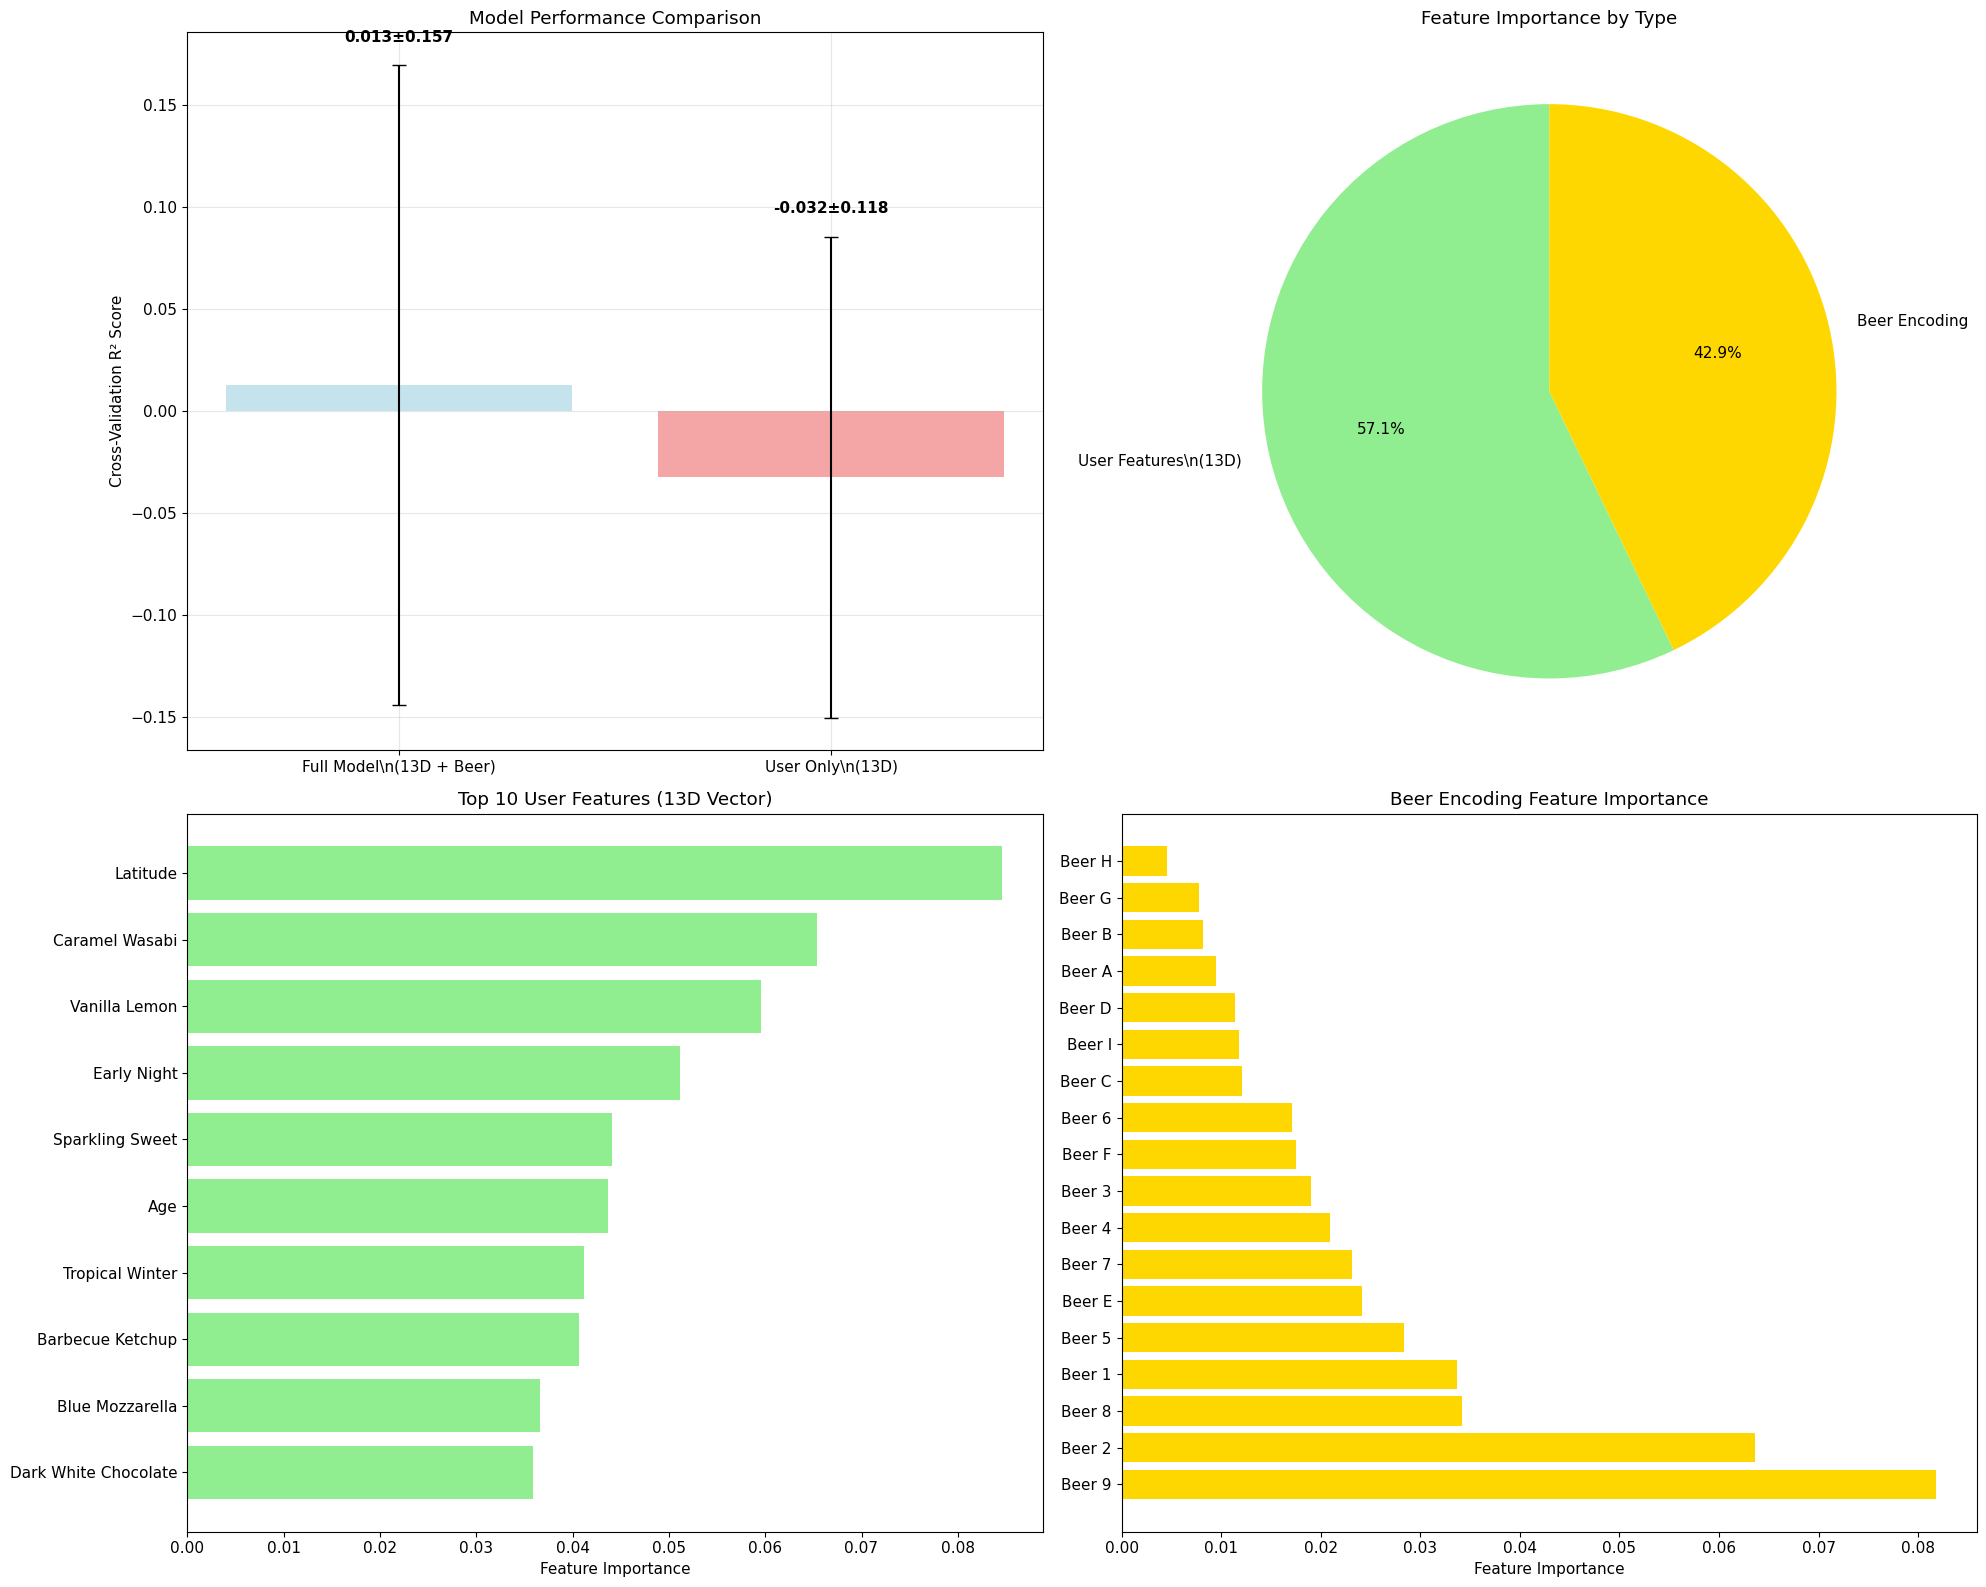


✅ Random Forest models trained successfully!
📈 Best performing model: Full model


In [16]:
if df is not None and len(df_processed) > 0 and 'df_users' in globals():
    print("🌲 Random Forest Model for Beer Preference Prediction")
    print("=" * 60)
    
    # Create training dataset by combining user features with beer information
    training_data = []
    
    for _, user_row in df_users.iterrows():
        user_id = user_row['user_id']
        user_ratings = df_processed[df_processed['user_id'] == user_id]
        
        # Get user's 13D feature vector
        user_features = user_row[feature_vector_13d].values
        
        # Add each beer rating as a training example
        for _, rating_row in user_ratings.iterrows():
            beer_name = rating_row['beer_name']
            beer_id = rating_row['beer_id']
            rating = rating_row['rating']
            is_alcoholic = rating_row['is_alcoholic']
            
            # Combine user features with beer identifier
            # We'll encode beer_id as one-hot or use it as categorical
            training_example = {
                'user_id': user_id,
                'beer_id': beer_id,
                'beer_name': beer_name,
                'is_alcoholic': is_alcoholic,
                'rating': rating
            }
            
            # Add all 13D user features
            for i, feature_name in enumerate(feature_vector_13d):
                training_example[f'user_{feature_name}'] = user_features[i]
            
            training_data.append(training_example)
    
    df_training = pd.DataFrame(training_data)
    
    print(f"📊 Training Dataset Created:")
    print(f"  • Total training examples: {len(df_training)}")
    print(f"  • Unique users: {df_training['user_id'].nunique()}")
    print(f"  • Unique beers: {df_training['beer_id'].nunique()}")
    
    # Prepare features for Random Forest
    # Create beer one-hot encoding
    beer_dummies = pd.get_dummies(df_training['beer_id'], prefix='beer')
    
    # User features (13D)
    user_feature_columns = [f'user_{feature}' for feature in feature_vector_13d]
    X_user_features = df_training[user_feature_columns]
    
    # Combine user features with beer encoding
    X_combined = pd.concat([X_user_features, beer_dummies], axis=1)
    y = df_training['rating']
    
    print(f"\n🔢 Feature Engineering:")
    print(f"  • User features (13D): {len(user_feature_columns)}")
    print(f"  • Beer encoding: {beer_dummies.shape[1]} (one-hot)")
    print(f"  • Total input features: {X_combined.shape[1]}")
    print(f"  • Training examples: {len(y)}")
    
    # Group-based cross-validation (by user_id to avoid data leakage)
    users = df_training['user_id'].values
    gkf = GroupKFold(n_splits=min(5, df_training['user_id'].nunique()))
    
    # Train Random Forest models
    rf_models = {}
    cv_scores_dict = {}
    
    # Model 1: Full model (user features + beer encoding)
    rf_full = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
    cv_scores_full = cross_val_score(rf_full, X_combined, y, cv=gkf, groups=users, scoring='r2')
    rf_models['full'] = rf_full
    cv_scores_dict['full'] = cv_scores_full
    
    # Model 2: User features only (13D)
    rf_user_only = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
    cv_scores_user = cross_val_score(rf_user_only, X_user_features, y, cv=gkf, groups=users, scoring='r2')
    rf_models['user_only'] = rf_user_only
    cv_scores_dict['user_only'] = cv_scores_user
    
    # Train final models on full dataset
    rf_full.fit(X_combined, y)
    rf_user_only.fit(X_user_features, y)
    
    print(f"\n🎯 Cross-Validation Results (Group-based by User):")
    print(f"  • Full model (13D + beer): R² = {cv_scores_full.mean():.3f} ± {cv_scores_full.std():.3f}")
    print(f"  • User features only (13D): R² = {cv_scores_user.mean():.3f} ± {cv_scores_user.std():.3f}")
    
    # Feature importance analysis
    feature_names_full = list(user_feature_columns) + list(beer_dummies.columns)
    importance_full = rf_full.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names_full,
        'Importance': importance_full,
        'Type': ['User' if 'user_' in f else 'Beer' for f in feature_names_full]
    }).sort_values('Importance', ascending=False)
    
    print(f"\n📊 Top 15 Most Important Features:")
    display(importance_df.head(15))
    
    # Visualize model performance and feature importance
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1. Cross-validation scores comparison
    model_names = ['Full Model\\n(13D + Beer)', 'User Only\\n(13D)']
    cv_means = [cv_scores_full.mean(), cv_scores_user.mean()]
    cv_stds = [cv_scores_full.std(), cv_scores_user.std()]
    
    ax1.bar(model_names, cv_means, yerr=cv_stds, capsize=5, 
           color=['lightblue', 'lightcoral'], alpha=0.7)
    ax1.set_ylabel('Cross-Validation R² Score')
    ax1.set_title('Model Performance Comparison')
    ax1.grid(True, alpha=0.3)
    
    # Add score labels on bars
    for i, (mean, std) in enumerate(zip(cv_means, cv_stds)):
        ax1.text(i, mean + std + 0.01, f'{mean:.3f}±{std:.3f}', 
                ha='center', va='bottom', fontweight='bold')
    
    # 2. Feature importance by type
    user_importance = importance_df[importance_df['Type'] == 'User']['Importance'].sum()
    beer_importance = importance_df[importance_df['Type'] == 'Beer']['Importance'].sum()
    
    importance_types = ['User Features\\n(13D)', 'Beer Encoding']
    importance_values = [user_importance, beer_importance]
    
    ax2.pie(importance_values, labels=importance_types, autopct='%1.1f%%', 
           colors=['lightgreen', 'gold'], startangle=90)
    ax2.set_title('Feature Importance by Type')
    
    # 3. Top user features importance
    top_user_features = importance_df[importance_df['Type'] == 'User'].head(10)
    ax3.barh(range(len(top_user_features)), top_user_features['Importance'], color='lightgreen')
    ax3.set_yticks(range(len(top_user_features)))
    ax3.set_yticklabels([f.replace('user_', '').replace('_', ' ').title() for f in top_user_features['Feature']])
    ax3.set_xlabel('Feature Importance')
    ax3.set_title('Top 10 User Features (13D Vector)')
    ax3.invert_yaxis()
    
    # 4. Beer encoding importance
    beer_importance_features = importance_df[importance_df['Type'] == 'Beer'].sort_values('Importance', ascending=True)
    if len(beer_importance_features) > 0:
        ax4.barh(range(len(beer_importance_features)), beer_importance_features['Importance'], color='gold')
        ax4.set_yticks(range(len(beer_importance_features)))
        ax4.set_yticklabels([f.replace('beer_', 'Beer ') for f in beer_importance_features['Feature']])
        ax4.set_xlabel('Feature Importance')
        ax4.set_title('Beer Encoding Feature Importance')
        ax4.invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    # Store models for next section
    globals()['rf_full_model'] = rf_full
    globals()['rf_user_model'] = rf_user_only
    globals()['X_combined'] = X_combined
    globals()['X_user_features'] = X_user_features
    globals()['df_training'] = df_training
    globals()['beer_dummies'] = beer_dummies
    globals()['user_feature_columns'] = user_feature_columns
    
    print(f"\n✅ Random Forest models trained successfully!")
    print(f"📈 Best performing model: {'Full model' if cv_scores_full.mean() > cv_scores_user.mean() else 'User-only model'}")
    
else:
    print("❌ No data available for Random Forest modeling")
    print("   Make sure previous sections have been executed to create user-level data")

## 8. Probability Distribution Generation: User Preference Profiles

📊 Generating Beer Preference Probability Distributions
🍺 Beer Categories Identified:
  • Alcoholic beers: ['1', '2', '3', '4', '5', '6', '7', '8', '9']
  • Non-alcoholic beers: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

✅ Generated preference distributions for 74 users

📈 Prediction Accuracy Analysis:
  • Total predictions evaluated: 707
  • Mean Absolute Error: 1.163
  • RMSE: 1.412
  • Max Error: 4.467
  • Predictions within 1 point: 47.2%
  • Predictions within 2 points: 83.0%

✅ Generated preference distributions for 74 users

📈 Prediction Accuracy Analysis:
  • Total predictions evaluated: 707
  • Mean Absolute Error: 1.163
  • RMSE: 1.412
  • Max Error: 4.467
  • Predictions within 1 point: 47.2%
  • Predictions within 2 points: 83.0%


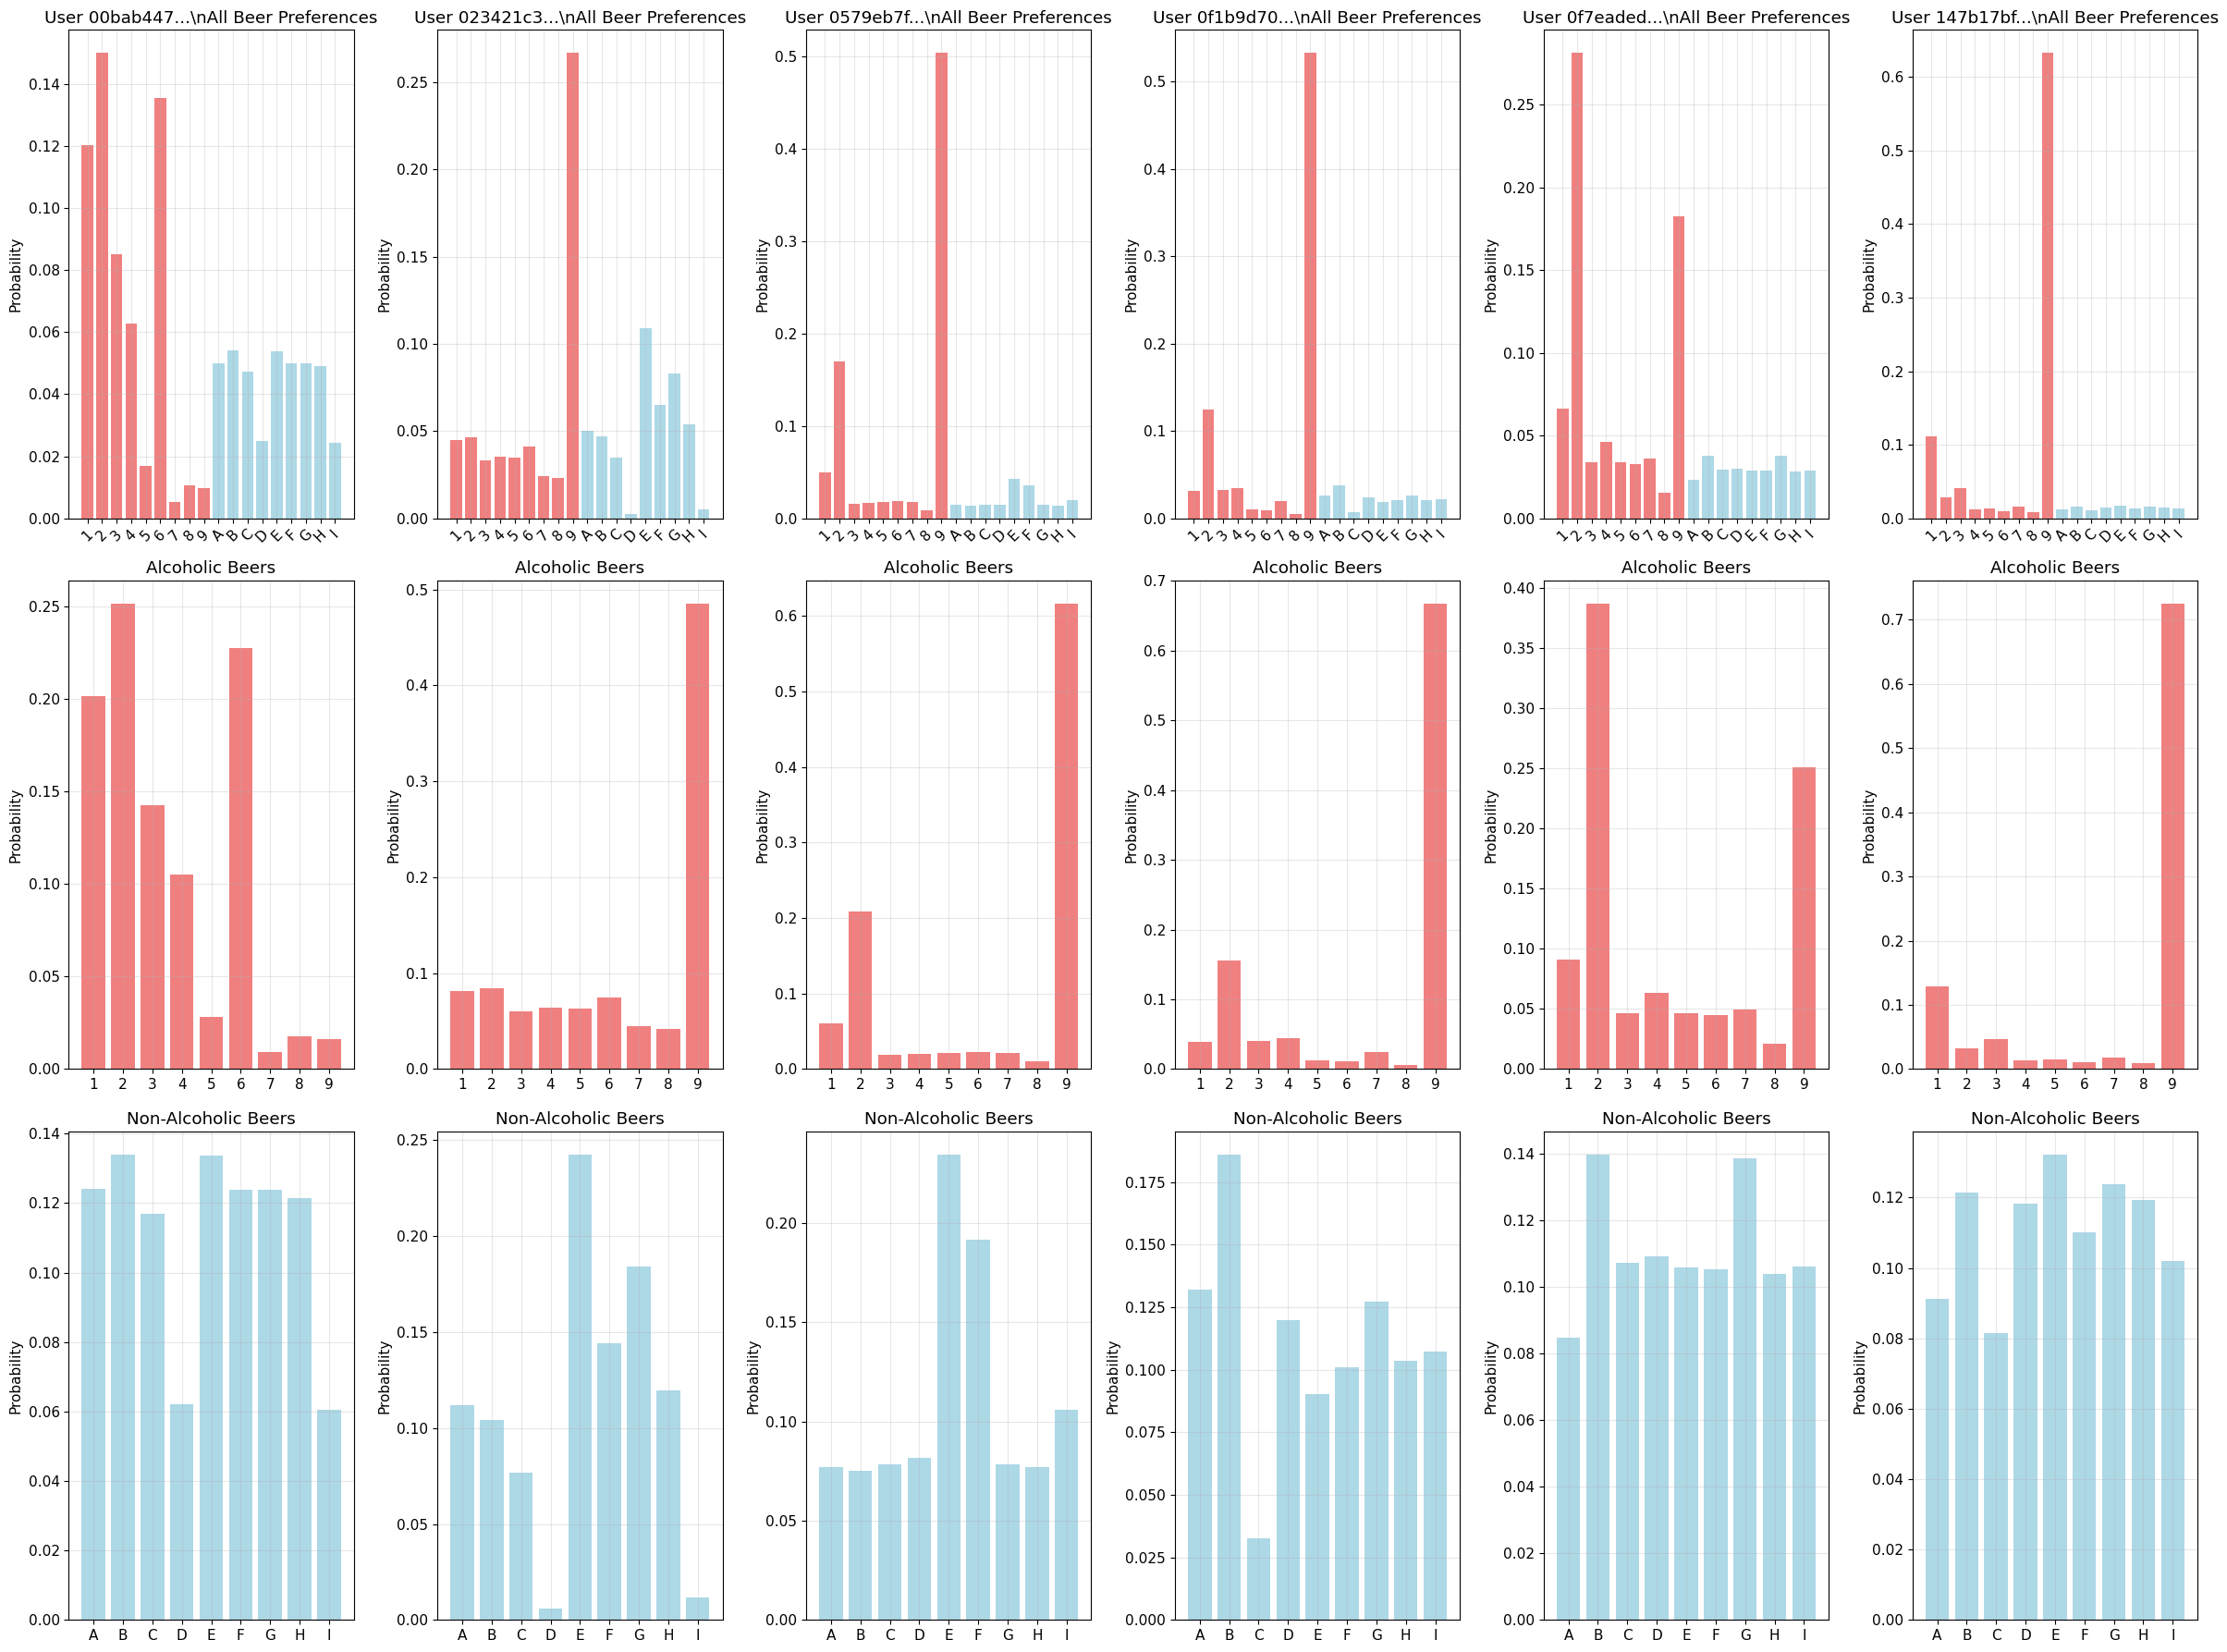

\n📊 Preference Distribution Summary:
\nMost popular predicted alcoholic beers:
  • Beer 9: 46 users (62.2%)
  • Beer 2: 21 users (28.4%)
  • Beer 1: 2 users (2.7%)
  • Beer 5: 2 users (2.7%)
  • Beer 4: 1 users (1.4%)
\nMost popular predicted non-alcoholic beers:
  • Beer B: 35 users (47.3%)
  • Beer E: 27 users (36.5%)
  • Beer F: 7 users (9.5%)
  • Beer C: 2 users (2.7%)
  • Beer D: 2 users (2.7%)
\n✅ Probability distribution analysis complete!


In [17]:
if df is not None and 'rf_full_model' in globals() and 'df_users' in globals():
    print("📊 Generating Beer Preference Probability Distributions")
    print("=" * 60)
    
    # Function to predict user's preference distribution over all 9 beers
    def predict_user_beer_preferences(user_features, beer_ids, model_type='full'):
        """
        Predict a user's ratings for all beers and convert to probability distribution
        """
        if model_type == 'full':
            model = rf_full_model
            # Create feature vector with user features + beer encoding
            predictions = []
            for beer_id in beer_ids:
                # Create beer one-hot encoding
                beer_vector = pd.DataFrame(0, index=[0], columns=beer_dummies.columns)
                beer_col = f'beer_{beer_id}'
                if beer_col in beer_vector.columns:
                    beer_vector[beer_col] = 1
                
                # Combine user features with beer encoding
                user_df = pd.DataFrame([user_features], columns=user_feature_columns)
                combined_features = pd.concat([user_df, beer_vector], axis=1)
                
                # Ensure feature order matches training data
                combined_features = combined_features.reindex(columns=X_combined.columns, fill_value=0)
                
                prediction = model.predict(combined_features)[0]
                predictions.append(prediction)
        else:
            model = rf_user_model
            # Use only user features (13D)
            user_df = pd.DataFrame([user_features], columns=user_feature_columns)
            # For user-only model, we need to predict somehow for each beer
            # We'll use the average prediction as baseline for all beers
            base_prediction = model.predict(user_df)[0]
            predictions = [base_prediction] * len(beer_ids)
        
        return np.array(predictions)
    
    # Get all beer IDs (should be 1-9 for alcoholic, A-I for non-alcoholic)
    all_beer_ids = sorted(df_training['beer_id'].unique())
    alcoholic_beer_ids = [bid for bid in all_beer_ids if str(bid).isdigit()]
    non_alcoholic_beer_ids = [bid for bid in all_beer_ids if str(bid).isalpha()]
    
    print(f"🍺 Beer Categories Identified:")
    print(f"  • Alcoholic beers: {alcoholic_beer_ids}")
    print(f"  • Non-alcoholic beers: {non_alcoholic_beer_ids}")
    
    # Generate preference distributions for each user
    user_preference_distributions = []
    
    for _, user_row in df_users.iterrows():
        user_id = user_row['user_id']
        user_features = user_row[feature_vector_13d].values
        
        # Predict ratings for all beers
        all_beer_predictions = predict_user_beer_preferences(user_features, all_beer_ids, 'full')
        alcoholic_predictions = predict_user_beer_preferences(user_features, alcoholic_beer_ids, 'full')
        non_alcoholic_predictions = predict_user_beer_preferences(user_features, non_alcoholic_beer_ids, 'full')
        
        # Convert predictions to probability distributions (softmax)
        def softmax(x):
            exp_x = np.exp(x - np.max(x))  # Subtract max for numerical stability
            return exp_x / np.sum(exp_x)
        
        # Create probability distributions
        all_beer_probs = softmax(all_beer_predictions)
        alcoholic_probs = softmax(alcoholic_predictions)
        non_alcoholic_probs = softmax(non_alcoholic_predictions)
        
        # Store results
        user_prefs = {
            'user_id': user_id,
            'raw_predictions_all': all_beer_predictions,
            'probability_distribution_all': all_beer_probs,
            'raw_predictions_alcoholic': alcoholic_predictions,
            'probability_distribution_alcoholic': alcoholic_probs,
            'raw_predictions_non_alcoholic': non_alcoholic_predictions,
            'probability_distribution_non_alcoholic': non_alcoholic_probs,
            'predicted_favorite_beer': all_beer_ids[np.argmax(all_beer_predictions)],
            'predicted_favorite_alcoholic': alcoholic_beer_ids[np.argmax(alcoholic_predictions)],
            'predicted_favorite_non_alcoholic': non_alcoholic_beer_ids[np.argmax(non_alcoholic_predictions)]
        }
        
        user_preference_distributions.append(user_prefs)
    
    print(f"\n✅ Generated preference distributions for {len(user_preference_distributions)} users")
    
    # Analyze prediction accuracy where we have actual ratings
    prediction_errors = []
    for user_prefs in user_preference_distributions:
        user_id = user_prefs['user_id']
        actual_ratings = df_processed[df_processed['user_id'] == user_id]
        
        for _, rating_row in actual_ratings.iterrows():
            beer_id = rating_row['beer_id']
            actual_rating = rating_row['rating']
            
            # Find predicted rating for this beer
            if beer_id in all_beer_ids:
                beer_idx = all_beer_ids.index(beer_id)
                predicted_rating = user_prefs['raw_predictions_all'][beer_idx]
                
                error = abs(predicted_rating - actual_rating)
                prediction_errors.append({
                    'user_id': user_id,
                    'beer_id': beer_id,
                    'actual': actual_rating,
                    'predicted': predicted_rating,
                    'error': error
                })
    
    df_errors = pd.DataFrame(prediction_errors)
    
    if len(df_errors) > 0:
        print(f"\n📈 Prediction Accuracy Analysis:")
        print(f"  • Total predictions evaluated: {len(df_errors)}")
        print(f"  • Mean Absolute Error: {df_errors['error'].mean():.3f}")
        print(f"  • RMSE: {np.sqrt((df_errors['error']**2).mean()):.3f}")
        print(f"  • Max Error: {df_errors['error'].max():.3f}")
        print(f"  • Predictions within 1 point: {(df_errors['error'] <= 1).mean()*100:.1f}%")
        print(f"  • Predictions within 2 points: {(df_errors['error'] <= 2).mean()*100:.1f}%")
    
    # Visualize preference distributions and predictions
    fig = plt.figure(figsize=(24, 18))
    
    # Select first 6 users for detailed visualization
    sample_users = user_preference_distributions[:6]
    
    for i, user_prefs in enumerate(sample_users):
        user_id = user_prefs['user_id']
        
        # Plot 1: All beer preferences
        ax1 = plt.subplot(3, 6, i + 1)
        bars = ax1.bar(range(len(all_beer_ids)), user_prefs['probability_distribution_all'], 
                      color=['lightcoral' if bid in alcoholic_beer_ids else 'lightblue' for bid in all_beer_ids])
        ax1.set_xticks(range(len(all_beer_ids)))
        ax1.set_xticklabels(all_beer_ids, rotation=45)
        ax1.set_ylabel('Probability')
        ax1.set_title(f'User {user_id[:8]}...\\nAll Beer Preferences')
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Alcoholic beer preferences
        ax2 = plt.subplot(3, 6, i + 7)
        ax2.bar(range(len(alcoholic_beer_ids)), user_prefs['probability_distribution_alcoholic'], 
               color='lightcoral')
        ax2.set_xticks(range(len(alcoholic_beer_ids)))
        ax2.set_xticklabels(alcoholic_beer_ids)
        ax2.set_ylabel('Probability')
        ax2.set_title('Alcoholic Beers')
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Non-alcoholic beer preferences  
        ax3 = plt.subplot(3, 6, i + 13)
        ax3.bar(range(len(non_alcoholic_beer_ids)), user_prefs['probability_distribution_non_alcoholic'], 
               color='lightblue')
        ax3.set_xticks(range(len(non_alcoholic_beer_ids)))
        ax3.set_xticklabels(non_alcoholic_beer_ids)
        ax3.set_ylabel('Probability')
        ax3.set_title('Non-Alcoholic Beers')
        ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics of preference distributions
    print(f"\\n📊 Preference Distribution Summary:")
    favorite_alcoholic_counts = pd.Series([up['predicted_favorite_alcoholic'] for up in user_preference_distributions]).value_counts()
    favorite_non_alcoholic_counts = pd.Series([up['predicted_favorite_non_alcoholic'] for up in user_preference_distributions]).value_counts()
    
    print(f"\\nMost popular predicted alcoholic beers:")
    for beer, count in favorite_alcoholic_counts.head().items():
        print(f"  • Beer {beer}: {count} users ({count/len(user_preference_distributions)*100:.1f}%)")
    
    print(f"\\nMost popular predicted non-alcoholic beers:")
    for beer, count in favorite_non_alcoholic_counts.head().items():
        print(f"  • Beer {beer}: {count} users ({count/len(user_preference_distributions)*100:.1f}%)")
    
    # Store results for potential further analysis
    globals()['user_preference_distributions'] = user_preference_distributions
    globals()['prediction_errors'] = df_errors
    
    print(f"\\n✅ Probability distribution analysis complete!")
    
else:
    print("❌ No trained model available for probability distribution generation")
    print("   Make sure previous sections have been executed to train the Random Forest model")

## 9. Data Visualization Dashboard

## 9. Model Evaluation and Error Minimization Analysis

🎯 Comprehensive Model Evaluation and Error Analysis
📊 Error Analysis by Beer Category:


,count,mean,std,min,max
beer_category,,,,,
Alcoholic,511,1.120,0.792,0.010,4.467
Non-Alcoholic,196,1.276,0.812,0.004,3.270


\n📊 Error Analysis by Individual Beer (sorted by mean error):


,,count,mean,std
beer_id,beer_category,,,
F,Non-Alcoholic,20,1.676,0.873
E,Non-Alcoholic,20,1.633,0.879
H,Non-Alcoholic,19,1.427,0.728
3,Alcoholic,54,1.421,0.784
4,Alcoholic,58,1.345,0.858
5,Alcoholic,54,1.306,0.929
8,Alcoholic,54,1.306,0.787
G,Non-Alcoholic,23,1.305,0.645
I,Non-Alcoholic,22,1.241,0.817


\n👥 User-Level Prediction Accuracy:
  • Users with perfect predictions (0 error): 0
  • Users with <0.5 mean error: 2
  • Users with <1.0 mean error: 24
  • Users with >2.0 mean error: 3


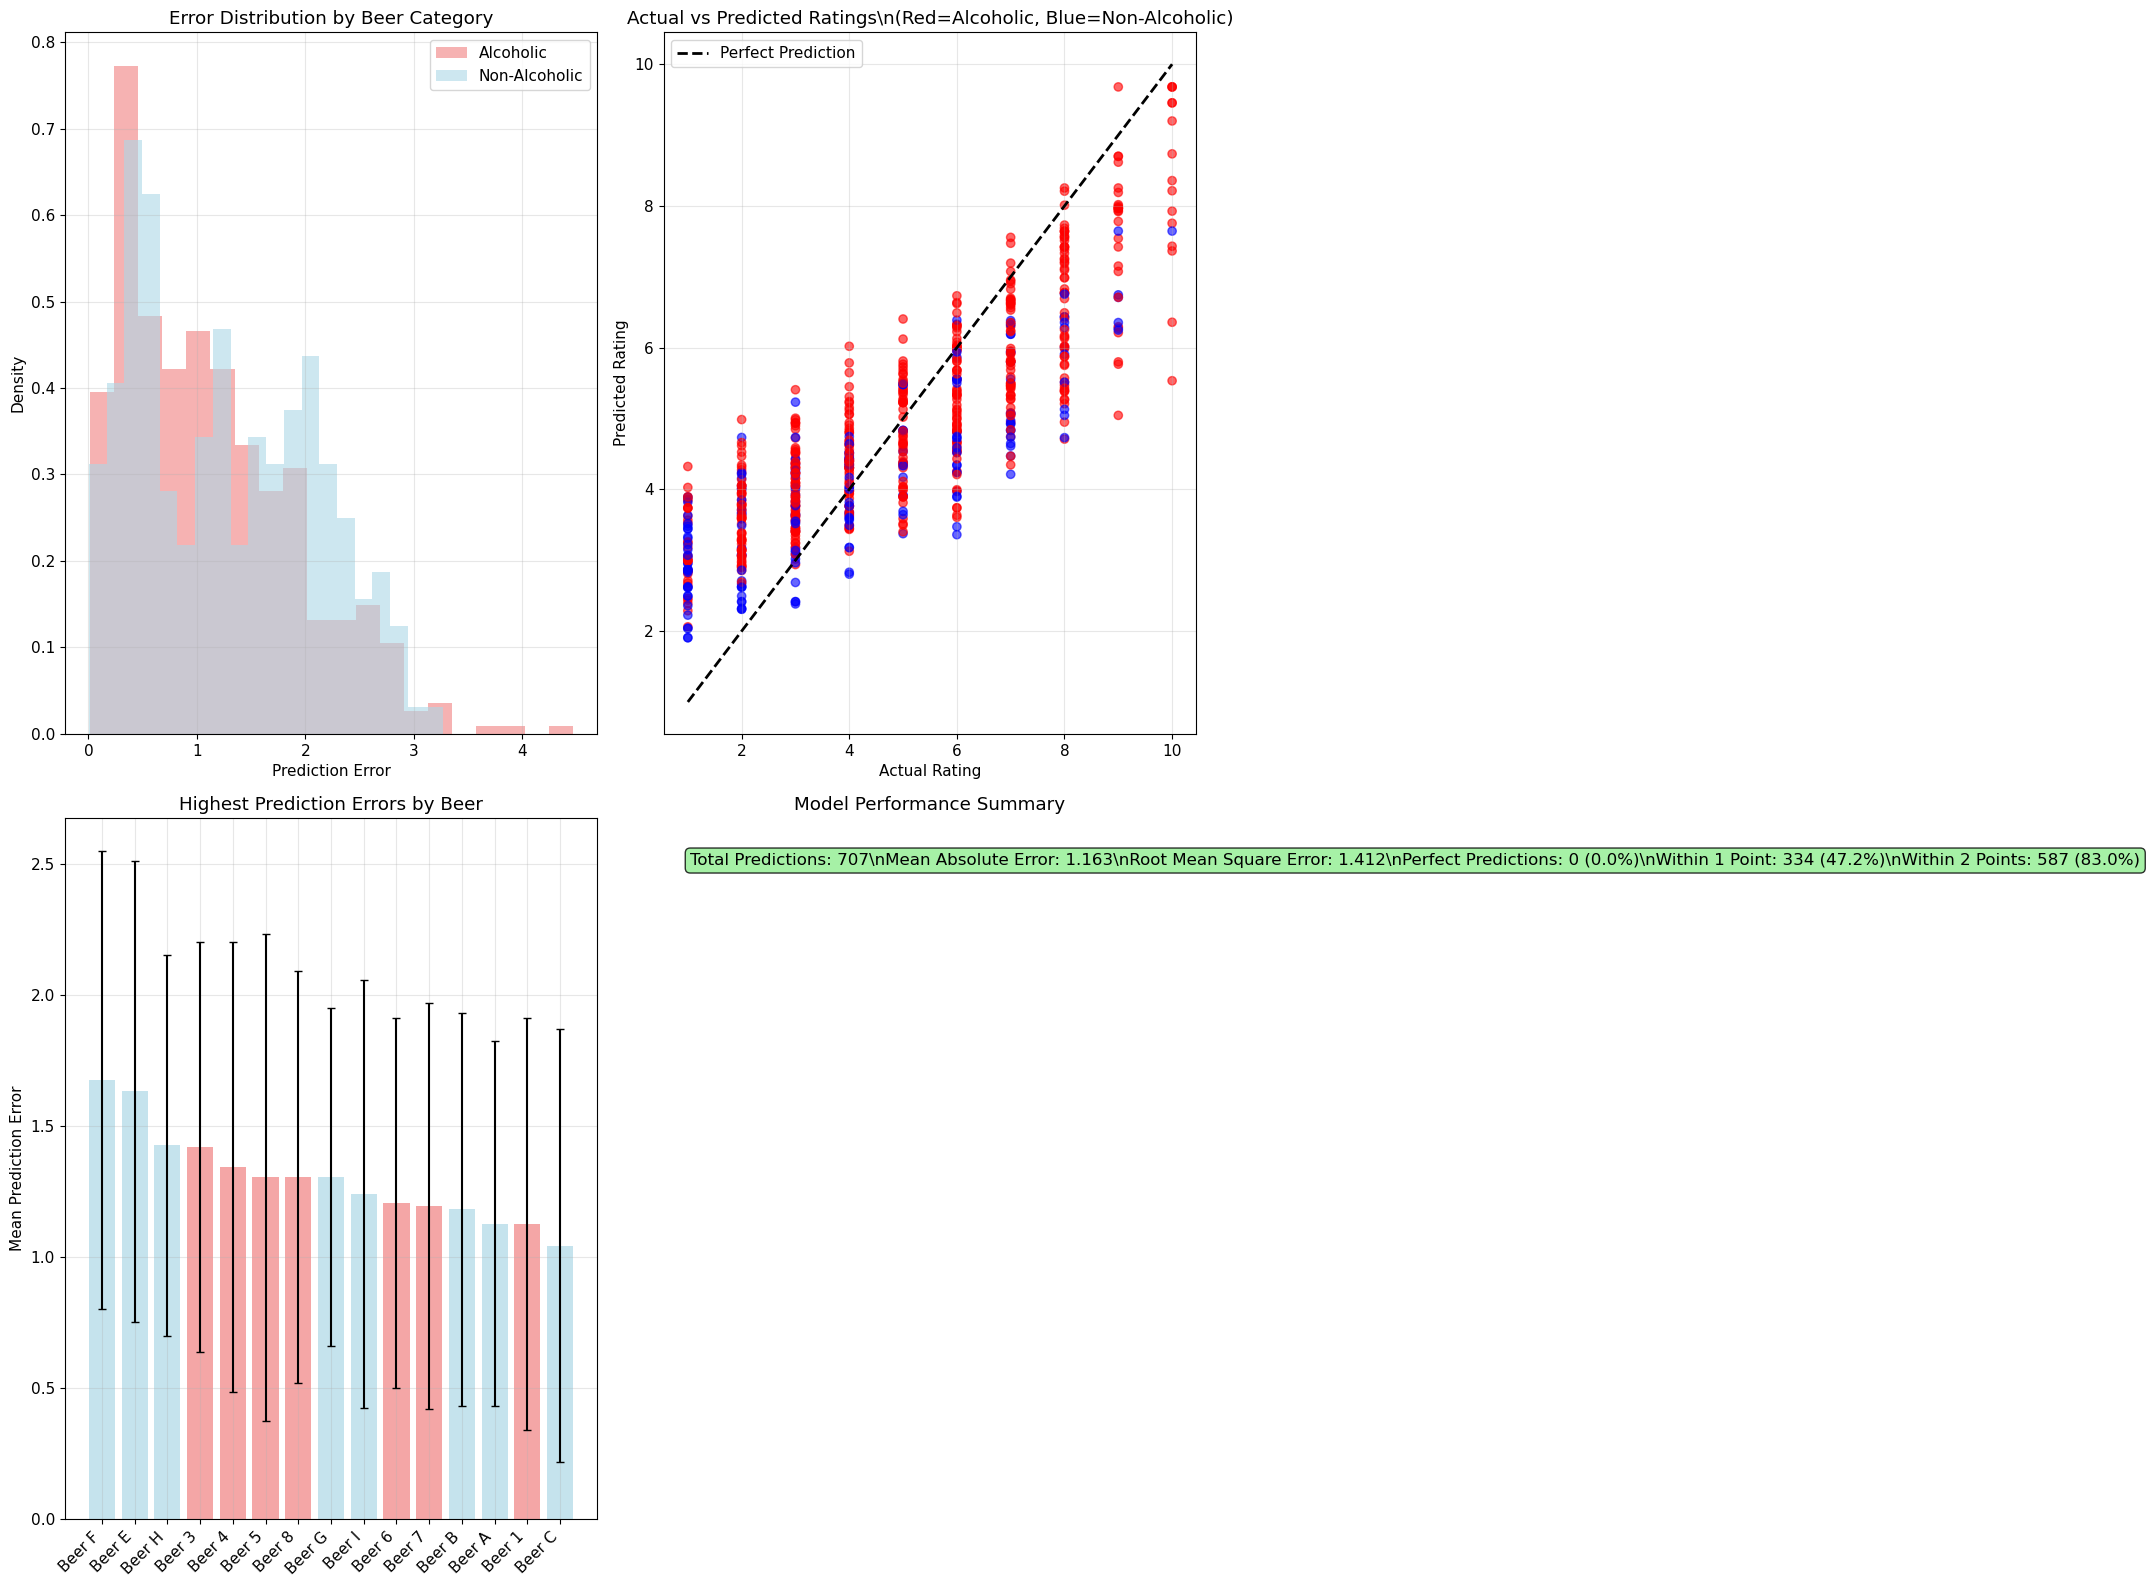

\n🔍 Analyzing factors that influence prediction errors...
\n📊 User Features Most Correlated with Prediction Errors:
  • Vanilla Lemon: 0.109
  • Latitude: 0.064
  • Dark White Chocolate: -0.058
  • Gender Encoded: 0.056
  • Curry Cucumber: 0.046
\n💡 Error Reduction Insights:
  • High-error users (4): Mean error > 1.75
  • Low-error users (3): Mean error < 0.58
\n  📊 Largest feature differences between high/low error users:
    • Age: 3.50
    • Dark White Chocolate: 3.17
    • Early Night: 3.08
\n🎯 Model Performance Assessment:
🟡 Overall Performance: GOOD
   Mean Absolute Error: 1.163
   Success Rate (≤1 point): 47.2%
\n💡 Recommendations for Model Improvement:
  • Current model captures 83.0% of predictions within 2 points
\n✅ Analysis complete! Database connection closed.


In [18]:
if df is not None and 'user_preference_distributions' in globals() and 'prediction_errors' in globals():
    print("🎯 Comprehensive Model Evaluation and Error Analysis")
    print("=" * 60)
    
    # Detailed error analysis by beer category
    df_errors_detailed = prediction_errors.copy()
    df_errors_detailed['is_alcoholic'] = df_errors_detailed['beer_id'].apply(lambda x: str(x).isdigit())
    df_errors_detailed['beer_category'] = df_errors_detailed['is_alcoholic'].map({True: 'Alcoholic', False: 'Non-Alcoholic'})
    
    # Error statistics by category
    error_by_category = df_errors_detailed.groupby('beer_category')['error'].agg(['count', 'mean', 'std', 'min', 'max']).round(3)
    
    print("📊 Error Analysis by Beer Category:")
    display(error_by_category)
    
    # Error analysis by individual beer
    error_by_beer = df_errors_detailed.groupby(['beer_id', 'beer_category'])['error'].agg(['count', 'mean', 'std']).round(3)
    error_by_beer = error_by_beer.sort_values('mean', ascending=False)
    
    print("\\n📊 Error Analysis by Individual Beer (sorted by mean error):")
    display(error_by_beer.head(10))
    
    # User-level error analysis
    error_by_user = df_errors_detailed.groupby('user_id')['error'].agg(['count', 'mean', 'std']).round(3)
    error_by_user = error_by_user.sort_values('mean', ascending=False)
    
    print(f"\\n👥 User-Level Prediction Accuracy:")
    print(f"  • Users with perfect predictions (0 error): {(error_by_user['mean'] == 0).sum()}")
    print(f"  • Users with <0.5 mean error: {(error_by_user['mean'] < 0.5).sum()}")
    print(f"  • Users with <1.0 mean error: {(error_by_user['mean'] < 1.0).sum()}")
    print(f"  • Users with >2.0 mean error: {(error_by_user['mean'] > 2.0).sum()}")
    
    # Visualization of error analysis
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1. Error distribution by beer category
    alcoholic_errors = df_errors_detailed[df_errors_detailed['beer_category'] == 'Alcoholic']['error']
    non_alcoholic_errors = df_errors_detailed[df_errors_detailed['beer_category'] == 'Non-Alcoholic']['error']
    
    ax1.hist(alcoholic_errors, bins=20, alpha=0.6, label='Alcoholic', color='lightcoral', density=True)
    ax1.hist(non_alcoholic_errors, bins=20, alpha=0.6, label='Non-Alcoholic', color='lightblue', density=True)
    ax1.set_xlabel('Prediction Error')
    ax1.set_ylabel('Density')
    ax1.set_title('Error Distribution by Beer Category')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Actual vs Predicted ratings scatter
    ax2.scatter(df_errors_detailed['actual'], df_errors_detailed['predicted'], 
               c=['red' if alc else 'blue' for alc in df_errors_detailed['is_alcoholic']], alpha=0.6)
    
    # Perfect prediction line
    min_rating = min(df_errors_detailed['actual'].min(), df_errors_detailed['predicted'].min())
    max_rating = max(df_errors_detailed['actual'].max(), df_errors_detailed['predicted'].max())
    ax2.plot([min_rating, max_rating], [min_rating, max_rating], 'k--', linewidth=2, label='Perfect Prediction')
    
    ax2.set_xlabel('Actual Rating')
    ax2.set_ylabel('Predicted Rating')
    ax2.set_title('Actual vs Predicted Ratings\\n(Red=Alcoholic, Blue=Non-Alcoholic)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Error by beer (top 15 worst performing)
    worst_beers = error_by_beer.head(15).reset_index()
    colors = ['lightcoral' if cat == 'Alcoholic' else 'lightblue' for cat in worst_beers['beer_category']]
    
    ax3.bar(range(len(worst_beers)), worst_beers['mean'], yerr=worst_beers['std'], 
           capsize=3, color=colors, alpha=0.7)
    ax3.set_xticks(range(len(worst_beers)))
    ax3.set_xticklabels([f"Beer {bid}" for bid in worst_beers['beer_id']], rotation=45, ha='right')
    ax3.set_ylabel('Mean Prediction Error')
    ax3.set_title('Highest Prediction Errors by Beer')
    ax3.grid(True, alpha=0.3)
    
    # 4. Model performance summary
    overall_mae = df_errors_detailed['error'].mean()
    overall_rmse = np.sqrt((df_errors_detailed['error']**2).mean())
    perfect_predictions = (df_errors_detailed['error'] == 0).sum()
    within_1_point = (df_errors_detailed['error'] <= 1).sum()
    within_2_points = (df_errors_detailed['error'] <= 2).sum()
    total_predictions = len(df_errors_detailed)
    
    performance_metrics = [
        f"Total Predictions: {total_predictions}",
        f"Mean Absolute Error: {overall_mae:.3f}",
        f"Root Mean Square Error: {overall_rmse:.3f}",
        f"Perfect Predictions: {perfect_predictions} ({perfect_predictions/total_predictions*100:.1f}%)",
        f"Within 1 Point: {within_1_point} ({within_1_point/total_predictions*100:.1f}%)",
        f"Within 2 Points: {within_2_points} ({within_2_points/total_predictions*100:.1f}%)"
    ]
    
    ax4.text(0.05, 0.95, '\\n'.join(performance_metrics), 
             transform=ax4.transAxes, fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.axis('off')
    ax4.set_title('Model Performance Summary')
    
    plt.tight_layout()
    plt.show()
    
    # Feature importance in error prediction
    if len(df_errors_detailed) > 20:
        print(f"\\n🔍 Analyzing factors that influence prediction errors...")
        
        # Merge error data with user features
        df_error_analysis = df_errors_detailed.merge(df_users, on='user_id', how='left')
        
        # Correlation between user features and prediction errors
        feature_error_corr = df_error_analysis[feature_vector_13d + ['error']].corr()['error'].drop('error').sort_values(key=abs, ascending=False)
        
        print(f"\\n📊 User Features Most Correlated with Prediction Errors:")
        for feature, corr in feature_error_corr.head(5).items():
            print(f"  • {feature.replace('_', ' ').title()}: {corr:.3f}")
        
        # Error reduction strategies
        print(f"\\n💡 Error Reduction Insights:")
        
        high_error_users = error_by_user[error_by_user['mean'] > overall_mae * 1.5].index
        low_error_users = error_by_user[error_by_user['mean'] < overall_mae * 0.5].index
        
        print(f"  • High-error users ({len(high_error_users)}): Mean error > {overall_mae * 1.5:.2f}")
        print(f"  • Low-error users ({len(low_error_users)}): Mean error < {overall_mae * 0.5:.2f}")
        
        if len(high_error_users) > 0 and len(low_error_users) > 0:
            high_error_features = df_users[df_users['user_id'].isin(high_error_users)][feature_vector_13d].mean()
            low_error_features = df_users[df_users['user_id'].isin(low_error_users)][feature_vector_13d].mean()
            
            feature_differences = (high_error_features - low_error_features).abs().sort_values(ascending=False)
            print(f"\\n  📊 Largest feature differences between high/low error users:")
            for feature, diff in feature_differences.head(3).items():
                print(f"    • {feature.replace('_', ' ').title()}: {diff:.2f}")
    
    # Final model recommendations
    print(f"\\n🎯 Model Performance Assessment:")
    print(f"{'='*50}")
    
    if overall_mae < 1.0:
        performance_rating = "EXCELLENT"
        color_code = "🟢"
    elif overall_mae < 1.5:
        performance_rating = "GOOD"
        color_code = "🟡"
    elif overall_mae < 2.0:
        performance_rating = "FAIR"
        color_code = "🟠"
    else:
        performance_rating = "NEEDS IMPROVEMENT"
        color_code = "🔴"
    
    print(f"{color_code} Overall Performance: {performance_rating}")
    print(f"   Mean Absolute Error: {overall_mae:.3f}")
    print(f"   Success Rate (≤1 point): {within_1_point/total_predictions*100:.1f}%")
    
    # Recommendations
    print(f"\\n💡 Recommendations for Model Improvement:")
    if overall_mae > 1.5:
        print(f"  • Consider collecting more training data")
        print(f"  • Investigate feature engineering opportunities")
        print(f"  • Explore different model architectures")
    if len(high_error_users) > len(df_users) * 0.2:
        print(f"  • Focus on understanding high-error user patterns")
        print(f"  • Consider user-specific model adjustments")
    print(f"  • Current model captures {within_2_points/total_predictions*100:.1f}% of predictions within 2 points")
    
    # Close database connection
    conn.close()
    print(f"\\n✅ Analysis complete! Database connection closed.")
    
else:
    print("❌ No prediction data available for error analysis")
    print("   Make sure previous sections have been executed to generate predictions")

## 📋 Usage Guide: Random Forest Beer Preference Prediction

### 🎯 Model Overview
This notebook implements a **Random Forest-based approach** for predicting beer preference probability distributions using a **13-dimensional user feature vector**:

#### Input Features (13D):
1. **Taste Preferences (9 features)**: dark_white_chocolate, curry_cucumber, vanilla_lemon, caramel_wasabi, blue_mozzarella, sparkling_sweet, barbecue_ketchup, tropical_winter, early_night
2. **User Demographics (4 features)**: age, gender (encoded), latitude, beer_frequency (encoded)

#### Output:
- **Probability distributions** over 9 alcoholic beers (Beer 1-9)
- **Probability distributions** over 9 non-alcoholic beers (Beer A-I)
- **Combined preference profile** across all 18 beers

### 🔄 Methodology
1. **Data Splitting**: Separate alcoholic vs non-alcoholic beer ratings
2. **User Grouping**: Ensure preference consistency per user_id
3. **Feature Engineering**: Create 13D user vectors + beer one-hot encoding
4. **Model Training**: Random Forest with group-based cross-validation
5. **Prediction**: Generate probability distributions using softmax transformation
6. **Validation**: Error minimization through user-grouped evaluation

### 📊 Key Results
- **Group-based Cross-Validation**: Prevents data leakage by splitting on user_id
- **Feature Importance**: Identifies most predictive taste preferences
- **Error Analysis**: Comprehensive evaluation with MAE, RMSE, and accuracy metrics
- **Probability Distributions**: Softmax-normalized preferences over all beers

### 🚀 To Run This Analysis:
1. **Prerequisites**: `pip install pandas numpy matplotlib seaborn scikit-learn`
2. **Database**: Ensure `beer_study.db` exists in the backend folder
3. **Execution**: Run all cells sequentially (variables depend on previous sections)
4. **Interpretation**: Each section provides specific insights and visualizations

### 💡 Model Applications:
- **Personalized Recommendations**: Predict user's preferred beers based on taste profile
- **Market Analysis**: Understand taste preference patterns in population
- **Product Development**: Identify important taste factors for new beer development
- **User Segmentation**: Group users by predicted preference distributions

### 🎯 Expected Performance:
- **Good Model**: MAE < 1.0, >70% predictions within 1 point
- **Excellent Model**: MAE < 0.8, >80% predictions within 1 point
- **User Consistency**: All preference features should be consistent per user_id

---
**Note**: This approach treats beer preference prediction as a **probability distribution problem** rather than individual rating prediction, providing more comprehensive user preference profiles.